In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4472112, 828)
(4472112, 8)
validation
(638000, 828)
(638000, 8)
test
(493136, 828)
(493136, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/448 [..............................] - ETA: 9:23 - loss: 2.3098 - STD: 0.0747 - MAE: 0.2196

  5/448 [..............................] - ETA: 6s - loss: 2.1307 - STD: 0.0563 - MAE: 0.2168  

  9/448 [..............................] - ETA: 6s - loss: 2.1124 - STD: 0.0512 - MAE: 0.2168

 13/448 [..............................] - ETA: 6s - loss: 2.0954 - STD: 0.0470 - MAE: 0.2167

 17/448 [>.............................] - ETA: 6s - loss: 2.0862 - STD: 0.0444 - MAE: 0.2166

 21/448 [>.............................] - ETA: 6s - loss: 2.0794 - STD: 0.0418 - MAE: 0.2167

 25/448 [>.............................] - ETA: 6s - loss: 2.0723 - STD: 0.0403 - MAE: 0.2166

 29/448 [>.............................] - ETA: 6s - loss: 2.0652 - STD: 0.0397 - MAE: 0.2164

 33/448 [=>............................] - ETA: 6s - loss: 2.0561 - STD: 0.0394 - MAE: 0.2162

 37/448 [=>............................] - ETA: 6s - loss: 2.0448 - STD: 0.0401 - MAE: 0.2158

 41/448 [=>............................] - ETA: 6s - loss: 2.0321 - STD: 0.0418 - MAE: 0.2152

 45/448 [==>...........................] - ETA: 6s - loss: 2.0189 - STD: 0.0439 - MAE: 0.2146

 49/448 [==>...........................] - ETA: 6s - loss: 2.0058 - STD: 0.0464 - MAE: 0.2140

 53/448 [==>...........................] - ETA: 6s - loss: 1.9918 - STD: 0.0486 - MAE: 0.2133

 57/448 [==>...........................] - ETA: 6s - loss: 1.9771 - STD: 0.0508 - MAE: 0.2126

 61/448 [===>..........................] - ETA: 6s - loss: 1.9622 - STD: 0.0530 - MAE: 0.2119

 65/448 [===>..........................] - ETA: 5s - loss: 1.9469 - STD: 0.0550 - MAE: 0.2112

 69/448 [===>..........................] - ETA: 5s - loss: 1.9308 - STD: 0.0571 - MAE: 0.2103

 73/448 [===>..........................] - ETA: 5s - loss: 1.9140 - STD: 0.0595 - MAE: 0.2094

 77/448 [====>.........................] - ETA: 5s - loss: 1.8969 - STD: 0.0621 - MAE: 0.2084

 80/448 [====>.........................] - ETA: 5s - loss: 1.8840 - STD: 0.0641 - MAE: 0.2076

 84/448 [====>.........................] - ETA: 5s - loss: 1.8676 - STD: 0.0668 - MAE: 0.2065

 88/448 [====>.........................] - ETA: 5s - loss: 1.8518 - STD: 0.0696 - MAE: 0.2054

 92/448 [=====>........................] - ETA: 5s - loss: 1.8366 - STD: 0.0722 - MAE: 0.2044

 96/448 [=====>........................] - ETA: 5s - loss: 1.8222 - STD: 0.0747 - MAE: 0.2034

100/448 [=====>........................] - ETA: 5s - loss: 1.8086 - STD: 0.0771 - MAE: 0.2024

104/448 [=====>........................] - ETA: 5s - loss: 1.7955 - STD: 0.0795 - MAE: 0.2015

108/448 [======>.......................] - ETA: 5s - loss: 1.7829 - STD: 0.0817 - MAE: 0.2006

112/448 [======>.......................] - ETA: 5s - loss: 1.7707 - STD: 0.0839 - MAE: 0.1997

115/448 [======>.......................] - ETA: 6s - loss: 1.7640 - STD: 0.0854 - MAE: 0.1990

119/448 [======>.......................] - ETA: 6s - loss: 1.7525 - STD: 0.0875 - MAE: 0.1982

123/448 [=======>......................] - ETA: 6s - loss: 1.7420 - STD: 0.0894 - MAE: 0.1974

127/448 [=======>......................] - ETA: 6s - loss: 1.7319 - STD: 0.0912 - MAE: 0.1967

131/448 [=======>......................] - ETA: 6s - loss: 1.7221 - STD: 0.0929 - MAE: 0.1959

135/448 [========>.....................] - ETA: 6s - loss: 1.7122 - STD: 0.0946 - MAE: 0.1952

139/448 [========>.....................] - ETA: 6s - loss: 1.7029 - STD: 0.0962 - MAE: 0.1945

143/448 [========>.....................] - ETA: 5s - loss: 1.6944 - STD: 0.0977 - MAE: 0.1939

147/448 [========>.....................] - ETA: 5s - loss: 1.6860 - STD: 0.0991 - MAE: 0.1932

151/448 [=========>....................] - ETA: 5s - loss: 1.6781 - STD: 0.1005 - MAE: 0.1927

155/448 [=========>....................] - ETA: 5s - loss: 1.6703 - STD: 0.1018 - MAE: 0.1921

159/448 [=========>....................] - ETA: 5s - loss: 1.6627 - STD: 0.1031 - MAE: 0.1915

163/448 [=========>....................] - ETA: 5s - loss: 1.6552 - STD: 0.1044 - MAE: 0.1909

167/448 [==========>...................] - ETA: 5s - loss: 1.6485 - STD: 0.1056 - MAE: 0.1904

171/448 [==========>...................] - ETA: 5s - loss: 1.6417 - STD: 0.1068 - MAE: 0.1899

175/448 [==========>...................] - ETA: 5s - loss: 1.6352 - STD: 0.1080 - MAE: 0.1894

179/448 [==========>...................] - ETA: 4s - loss: 1.6288 - STD: 0.1090 - MAE: 0.1889

183/448 [===========>..................] - ETA: 4s - loss: 1.6225 - STD: 0.1101 - MAE: 0.1884

187/448 [===========>..................] - ETA: 4s - loss: 1.6166 - STD: 0.1112 - MAE: 0.1879

191/448 [===========>..................] - ETA: 4s - loss: 1.6108 - STD: 0.1122 - MAE: 0.1875

195/448 [============>.................] - ETA: 4s - loss: 1.6052 - STD: 0.1131 - MAE: 0.1870

199/448 [============>.................] - ETA: 4s - loss: 1.6003 - STD: 0.1141 - MAE: 0.1866

203/448 [============>.................] - ETA: 4s - loss: 1.5952 - STD: 0.1150 - MAE: 0.1862

207/448 [============>.................] - ETA: 4s - loss: 1.5904 - STD: 0.1159 - MAE: 0.1858

211/448 [=============>................] - ETA: 4s - loss: 1.5856 - STD: 0.1167 - MAE: 0.1854

215/448 [=============>................] - ETA: 4s - loss: 1.5808 - STD: 0.1176 - MAE: 0.1850

219/448 [=============>................] - ETA: 4s - loss: 1.5762 - STD: 0.1184 - MAE: 0.1846

223/448 [=============>................] - ETA: 4s - loss: 1.5715 - STD: 0.1192 - MAE: 0.1843

227/448 [==============>...............] - ETA: 3s - loss: 1.5671 - STD: 0.1200 - MAE: 0.1839

231/448 [==============>...............] - ETA: 3s - loss: 1.5627 - STD: 0.1207 - MAE: 0.1836

235/448 [==============>...............] - ETA: 3s - loss: 1.5584 - STD: 0.1214 - MAE: 0.1832

239/448 [===============>..............] - ETA: 3s - loss: 1.5543 - STD: 0.1222 - MAE: 0.1829

243/448 [===============>..............] - ETA: 3s - loss: 1.5502 - STD: 0.1228 - MAE: 0.1826

247/448 [===============>..............] - ETA: 3s - loss: 1.5463 - STD: 0.1235 - MAE: 0.1822

251/448 [===============>..............] - ETA: 3s - loss: 1.5425 - STD: 0.1242 - MAE: 0.1819

255/448 [================>.............] - ETA: 3s - loss: 1.5387 - STD: 0.1248 - MAE: 0.1816

259/448 [================>.............] - ETA: 3s - loss: 1.5349 - STD: 0.1255 - MAE: 0.1813

263/448 [================>.............] - ETA: 3s - loss: 1.5313 - STD: 0.1261 - MAE: 0.1810

267/448 [================>.............] - ETA: 3s - loss: 1.5279 - STD: 0.1267 - MAE: 0.1807

271/448 [=================>............] - ETA: 3s - loss: 1.5245 - STD: 0.1273 - MAE: 0.1804

275/448 [=================>............] - ETA: 3s - loss: 1.5213 - STD: 0.1279 - MAE: 0.1802

279/448 [=================>............] - ETA: 2s - loss: 1.5181 - STD: 0.1285 - MAE: 0.1799

283/448 [=================>............] - ETA: 2s - loss: 1.5148 - STD: 0.1290 - MAE: 0.1796

287/448 [==================>...........] - ETA: 2s - loss: 1.5116 - STD: 0.1296 - MAE: 0.1794

291/448 [==================>...........] - ETA: 2s - loss: 1.5085 - STD: 0.1301 - MAE: 0.1791

295/448 [==================>...........] - ETA: 2s - loss: 1.5055 - STD: 0.1306 - MAE: 0.1788

299/448 [===================>..........] - ETA: 2s - loss: 1.5026 - STD: 0.1311 - MAE: 0.1786

303/448 [===================>..........] - ETA: 2s - loss: 1.4997 - STD: 0.1316 - MAE: 0.1784

307/448 [===================>..........] - ETA: 2s - loss: 1.4968 - STD: 0.1321 - MAE: 0.1781

311/448 [===================>..........] - ETA: 2s - loss: 1.4939 - STD: 0.1326 - MAE: 0.1779

315/448 [====================>.........] - ETA: 2s - loss: 1.4910 - STD: 0.1331 - MAE: 0.1776

319/448 [====================>.........] - ETA: 2s - loss: 1.4884 - STD: 0.1335 - MAE: 0.1774

323/448 [====================>.........] - ETA: 2s - loss: 1.4857 - STD: 0.1340 - MAE: 0.1772

327/448 [====================>.........] - ETA: 2s - loss: 1.4830 - STD: 0.1344 - MAE: 0.1770

331/448 [=====================>........] - ETA: 1s - loss: 1.4803 - STD: 0.1349 - MAE: 0.1767

335/448 [=====================>........] - ETA: 1s - loss: 1.4778 - STD: 0.1353 - MAE: 0.1765

339/448 [=====================>........] - ETA: 1s - loss: 1.4753 - STD: 0.1358 - MAE: 0.1763

343/448 [=====================>........] - ETA: 1s - loss: 1.4730 - STD: 0.1362 - MAE: 0.1761

347/448 [======================>.......] - ETA: 1s - loss: 1.4705 - STD: 0.1366 - MAE: 0.1759

351/448 [======================>.......] - ETA: 1s - loss: 1.4681 - STD: 0.1370 - MAE: 0.1757

355/448 [======================>.......] - ETA: 1s - loss: 1.4657 - STD: 0.1374 - MAE: 0.1755

359/448 [=======================>......] - ETA: 1s - loss: 1.4633 - STD: 0.1378 - MAE: 0.1753

363/448 [=======================>......] - ETA: 1s - loss: 1.4610 - STD: 0.1382 - MAE: 0.1751

367/448 [=======================>......] - ETA: 1s - loss: 1.4586 - STD: 0.1386 - MAE: 0.1749

371/448 [=======================>......] - ETA: 1s - loss: 1.4563 - STD: 0.1390 - MAE: 0.1747

375/448 [========================>.....] - ETA: 1s - loss: 1.4540 - STD: 0.1393 - MAE: 0.1745

379/448 [========================>.....] - ETA: 1s - loss: 1.4518 - STD: 0.1397 - MAE: 0.1743

383/448 [========================>.....] - ETA: 1s - loss: 1.4497 - STD: 0.1401 - MAE: 0.1741

387/448 [========================>.....] - ETA: 1s - loss: 1.4474 - STD: 0.1404 - MAE: 0.1739

391/448 [=========================>....] - ETA: 0s - loss: 1.4453 - STD: 0.1408 - MAE: 0.1737

395/448 [=========================>....] - ETA: 0s - loss: 1.4431 - STD: 0.1411 - MAE: 0.1736

399/448 [=========================>....] - ETA: 0s - loss: 1.4412 - STD: 0.1415 - MAE: 0.1734

403/448 [=========================>....] - ETA: 0s - loss: 1.4393 - STD: 0.1418 - MAE: 0.1732

407/448 [==========================>...] - ETA: 0s - loss: 1.4373 - STD: 0.1422 - MAE: 0.1730

411/448 [==========================>...] - ETA: 0s - loss: 1.4355 - STD: 0.1425 - MAE: 0.1729

415/448 [==========================>...] - ETA: 0s - loss: 1.4338 - STD: 0.1428 - MAE: 0.1727

419/448 [===========================>..] - ETA: 0s - loss: 1.4319 - STD: 0.1431 - MAE: 0.1726

423/448 [===========================>..] - ETA: 0s - loss: 1.4300 - STD: 0.1434 - MAE: 0.1724

427/448 [===========================>..] - ETA: 0s - loss: 1.4281 - STD: 0.1437 - MAE: 0.1722

431/448 [===========================>..] - ETA: 0s - loss: 1.4261 - STD: 0.1440 - MAE: 0.1721

435/448 [============================>.] - ETA: 0s - loss: 1.4242 - STD: 0.1443 - MAE: 0.1719

439/448 [============================>.] - ETA: 0s - loss: 1.4225 - STD: 0.1446 - MAE: 0.1718

443/448 [============================>.] - ETA: 0s - loss: 1.4209 - STD: 0.1449 - MAE: 0.1716

447/448 [============================>.] - ETA: 0s - loss: 1.4191 - STD: 0.1452 - MAE: 0.1715

448/448 [==============================] - 10s 20ms/step - loss: 1.4187 - STD: 0.1453 - MAE: 0.1714 - val_loss: 1.3216 - val_STD: 0.1752 - val_MAE: 0.1589


Epoch 2/10000


  1/448 [..............................] - ETA: 25s - loss: 1.2325 - STD: 0.1769 - MAE: 0.1552

  4/448 [..............................] - ETA: 7s - loss: 1.2173 - STD: 0.1778 - MAE: 0.1541 

  8/448 [..............................] - ETA: 7s - loss: 1.2237 - STD: 0.1776 - MAE: 0.1545

 12/448 [..............................] - ETA: 6s - loss: 1.2203 - STD: 0.1776 - MAE: 0.1543

 15/448 [>.............................] - ETA: 7s - loss: 1.2206 - STD: 0.1777 - MAE: 0.1542

 19/448 [>.............................] - ETA: 6s - loss: 1.2216 - STD: 0.1779 - MAE: 0.1542

 23/448 [>.............................] - ETA: 6s - loss: 1.2235 - STD: 0.1779 - MAE: 0.1543

 27/448 [>.............................] - ETA: 6s - loss: 1.2222 - STD: 0.1778 - MAE: 0.1543

 31/448 [=>............................] - ETA: 6s - loss: 1.2214 - STD: 0.1779 - MAE: 0.1542

 35/448 [=>............................] - ETA: 6s - loss: 1.2201 - STD: 0.1780 - MAE: 0.1541

 39/448 [=>............................] - ETA: 6s - loss: 1.2186 - STD: 0.1781 - MAE: 0.1540

 43/448 [=>............................] - ETA: 6s - loss: 1.2176 - STD: 0.1783 - MAE: 0.1539

 47/448 [==>...........................] - ETA: 6s - loss: 1.2161 - STD: 0.1784 - MAE: 0.1538

 51/448 [==>...........................] - ETA: 6s - loss: 1.2150 - STD: 0.1786 - MAE: 0.1537

 55/448 [==>...........................] - ETA: 6s - loss: 1.2139 - STD: 0.1786 - MAE: 0.1536

 59/448 [==>...........................] - ETA: 6s - loss: 1.2127 - STD: 0.1787 - MAE: 0.1535

 63/448 [===>..........................] - ETA: 6s - loss: 1.2114 - STD: 0.1788 - MAE: 0.1534

 67/448 [===>..........................] - ETA: 5s - loss: 1.2106 - STD: 0.1790 - MAE: 0.1533

 71/448 [===>..........................] - ETA: 5s - loss: 1.2105 - STD: 0.1791 - MAE: 0.1532

 75/448 [====>.........................] - ETA: 5s - loss: 1.2099 - STD: 0.1792 - MAE: 0.1532

 79/448 [====>.........................] - ETA: 5s - loss: 1.2088 - STD: 0.1793 - MAE: 0.1531

 83/448 [====>.........................] - ETA: 5s - loss: 1.2091 - STD: 0.1794 - MAE: 0.1531

 87/448 [====>.........................] - ETA: 5s - loss: 1.2087 - STD: 0.1795 - MAE: 0.1530

 91/448 [=====>........................] - ETA: 5s - loss: 1.2080 - STD: 0.1796 - MAE: 0.1529

 95/448 [=====>........................] - ETA: 5s - loss: 1.2071 - STD: 0.1797 - MAE: 0.1529

 99/448 [=====>........................] - ETA: 5s - loss: 1.2064 - STD: 0.1798 - MAE: 0.1528

103/448 [=====>........................] - ETA: 5s - loss: 1.2061 - STD: 0.1798 - MAE: 0.1528

106/448 [======>.......................] - ETA: 5s - loss: 1.2054 - STD: 0.1799 - MAE: 0.1527

110/448 [======>.......................] - ETA: 5s - loss: 1.2048 - STD: 0.1800 - MAE: 0.1527

114/448 [======>.......................] - ETA: 5s - loss: 1.2039 - STD: 0.1801 - MAE: 0.1526

118/448 [======>.......................] - ETA: 5s - loss: 1.2030 - STD: 0.1802 - MAE: 0.1525

122/448 [=======>......................] - ETA: 5s - loss: 1.2026 - STD: 0.1803 - MAE: 0.1525

126/448 [=======>......................] - ETA: 5s - loss: 1.2026 - STD: 0.1804 - MAE: 0.1524

130/448 [=======>......................] - ETA: 4s - loss: 1.2019 - STD: 0.1804 - MAE: 0.1524

134/448 [=======>......................] - ETA: 4s - loss: 1.2010 - STD: 0.1805 - MAE: 0.1523

138/448 [========>.....................] - ETA: 4s - loss: 1.2004 - STD: 0.1806 - MAE: 0.1522

142/448 [========>.....................] - ETA: 4s - loss: 1.1997 - STD: 0.1807 - MAE: 0.1522

146/448 [========>.....................] - ETA: 4s - loss: 1.1993 - STD: 0.1808 - MAE: 0.1521

150/448 [=========>....................] - ETA: 4s - loss: 1.1990 - STD: 0.1809 - MAE: 0.1521

154/448 [=========>....................] - ETA: 4s - loss: 1.1984 - STD: 0.1809 - MAE: 0.1520

158/448 [=========>....................] - ETA: 4s - loss: 1.1978 - STD: 0.1810 - MAE: 0.1520

162/448 [=========>....................] - ETA: 4s - loss: 1.1976 - STD: 0.1811 - MAE: 0.1519

166/448 [==========>...................] - ETA: 4s - loss: 1.1975 - STD: 0.1812 - MAE: 0.1519

170/448 [==========>...................] - ETA: 4s - loss: 1.1970 - STD: 0.1812 - MAE: 0.1518

174/448 [==========>...................] - ETA: 4s - loss: 1.1965 - STD: 0.1813 - MAE: 0.1518

178/448 [==========>...................] - ETA: 4s - loss: 1.1965 - STD: 0.1814 - MAE: 0.1518

182/448 [===========>..................] - ETA: 4s - loss: 1.1962 - STD: 0.1814 - MAE: 0.1517

186/448 [===========>..................] - ETA: 4s - loss: 1.1957 - STD: 0.1815 - MAE: 0.1517

190/448 [===========>..................] - ETA: 4s - loss: 1.1948 - STD: 0.1816 - MAE: 0.1516

194/448 [===========>..................] - ETA: 3s - loss: 1.1940 - STD: 0.1816 - MAE: 0.1516

198/448 [============>.................] - ETA: 3s - loss: 1.1933 - STD: 0.1817 - MAE: 0.1515

202/448 [============>.................] - ETA: 3s - loss: 1.1925 - STD: 0.1818 - MAE: 0.1514

206/448 [============>.................] - ETA: 3s - loss: 1.1918 - STD: 0.1819 - MAE: 0.1514

210/448 [=============>................] - ETA: 3s - loss: 1.1912 - STD: 0.1820 - MAE: 0.1513

214/448 [=============>................] - ETA: 3s - loss: 1.1904 - STD: 0.1820 - MAE: 0.1512

218/448 [=============>................] - ETA: 3s - loss: 1.1899 - STD: 0.1821 - MAE: 0.1512

222/448 [=============>................] - ETA: 3s - loss: 1.1897 - STD: 0.1822 - MAE: 0.1511

226/448 [==============>...............] - ETA: 3s - loss: 1.1891 - STD: 0.1823 - MAE: 0.1511

230/448 [==============>...............] - ETA: 3s - loss: 1.1886 - STD: 0.1823 - MAE: 0.1510

234/448 [==============>...............] - ETA: 3s - loss: 1.1880 - STD: 0.1824 - MAE: 0.1510

238/448 [==============>...............] - ETA: 3s - loss: 1.1875 - STD: 0.1825 - MAE: 0.1509

242/448 [===============>..............] - ETA: 3s - loss: 1.1871 - STD: 0.1826 - MAE: 0.1509

246/448 [===============>..............] - ETA: 3s - loss: 1.1867 - STD: 0.1826 - MAE: 0.1508

250/448 [===============>..............] - ETA: 3s - loss: 1.1865 - STD: 0.1827 - MAE: 0.1508

254/448 [================>.............] - ETA: 3s - loss: 1.1861 - STD: 0.1828 - MAE: 0.1508

258/448 [================>.............] - ETA: 2s - loss: 1.1857 - STD: 0.1829 - MAE: 0.1507

262/448 [================>.............] - ETA: 2s - loss: 1.1852 - STD: 0.1829 - MAE: 0.1507

266/448 [================>.............] - ETA: 2s - loss: 1.1846 - STD: 0.1830 - MAE: 0.1506

270/448 [=================>............] - ETA: 2s - loss: 1.1839 - STD: 0.1831 - MAE: 0.1506

274/448 [=================>............] - ETA: 2s - loss: 1.1833 - STD: 0.1831 - MAE: 0.1505

278/448 [=================>............] - ETA: 2s - loss: 1.1827 - STD: 0.1832 - MAE: 0.1504

282/448 [=================>............] - ETA: 2s - loss: 1.1821 - STD: 0.1833 - MAE: 0.1504

286/448 [==================>...........] - ETA: 2s - loss: 1.1815 - STD: 0.1833 - MAE: 0.1503

290/448 [==================>...........] - ETA: 2s - loss: 1.1808 - STD: 0.1834 - MAE: 0.1503

294/448 [==================>...........] - ETA: 2s - loss: 1.1801 - STD: 0.1835 - MAE: 0.1502

298/448 [==================>...........] - ETA: 2s - loss: 1.1795 - STD: 0.1836 - MAE: 0.1502

302/448 [===================>..........] - ETA: 2s - loss: 1.1790 - STD: 0.1836 - MAE: 0.1501

306/448 [===================>..........] - ETA: 2s - loss: 1.1784 - STD: 0.1837 - MAE: 0.1500

310/448 [===================>..........] - ETA: 2s - loss: 1.1780 - STD: 0.1838 - MAE: 0.1500

314/448 [====================>.........] - ETA: 2s - loss: 1.1775 - STD: 0.1839 - MAE: 0.1499

318/448 [====================>.........] - ETA: 2s - loss: 1.1773 - STD: 0.1839 - MAE: 0.1499

322/448 [====================>.........] - ETA: 1s - loss: 1.1772 - STD: 0.1840 - MAE: 0.1499

326/448 [====================>.........] - ETA: 1s - loss: 1.1769 - STD: 0.1841 - MAE: 0.1498

330/448 [=====================>........] - ETA: 1s - loss: 1.1764 - STD: 0.1841 - MAE: 0.1498

334/448 [=====================>........] - ETA: 1s - loss: 1.1759 - STD: 0.1842 - MAE: 0.1497

338/448 [=====================>........] - ETA: 1s - loss: 1.1754 - STD: 0.1843 - MAE: 0.1497

342/448 [=====================>........] - ETA: 1s - loss: 1.1751 - STD: 0.1843 - MAE: 0.1497

346/448 [======================>.......] - ETA: 1s - loss: 1.1745 - STD: 0.1844 - MAE: 0.1496

350/448 [======================>.......] - ETA: 1s - loss: 1.1740 - STD: 0.1845 - MAE: 0.1496

354/448 [======================>.......] - ETA: 1s - loss: 1.1735 - STD: 0.1845 - MAE: 0.1495

358/448 [======================>.......] - ETA: 1s - loss: 1.1729 - STD: 0.1846 - MAE: 0.1495

362/448 [=======================>......] - ETA: 1s - loss: 1.1724 - STD: 0.1846 - MAE: 0.1494

366/448 [=======================>......] - ETA: 1s - loss: 1.1718 - STD: 0.1847 - MAE: 0.1494

370/448 [=======================>......] - ETA: 1s - loss: 1.1712 - STD: 0.1848 - MAE: 0.1493

374/448 [========================>.....] - ETA: 1s - loss: 1.1706 - STD: 0.1849 - MAE: 0.1492

378/448 [========================>.....] - ETA: 1s - loss: 1.1700 - STD: 0.1849 - MAE: 0.1492

382/448 [========================>.....] - ETA: 1s - loss: 1.1695 - STD: 0.1850 - MAE: 0.1491

386/448 [========================>.....] - ETA: 0s - loss: 1.1690 - STD: 0.1851 - MAE: 0.1491

390/448 [=========================>....] - ETA: 0s - loss: 1.1687 - STD: 0.1851 - MAE: 0.1490

394/448 [=========================>....] - ETA: 0s - loss: 1.1683 - STD: 0.1852 - MAE: 0.1490

398/448 [=========================>....] - ETA: 0s - loss: 1.1677 - STD: 0.1853 - MAE: 0.1489

402/448 [=========================>....] - ETA: 0s - loss: 1.1672 - STD: 0.1853 - MAE: 0.1489

406/448 [==========================>...] - ETA: 0s - loss: 1.1665 - STD: 0.1854 - MAE: 0.1488

410/448 [==========================>...] - ETA: 0s - loss: 1.1660 - STD: 0.1855 - MAE: 0.1488

414/448 [==========================>...] - ETA: 0s - loss: 1.1654 - STD: 0.1855 - MAE: 0.1487

417/448 [==========================>...] - ETA: 0s - loss: 1.1649 - STD: 0.1856 - MAE: 0.1487

421/448 [===========================>..] - ETA: 0s - loss: 1.1645 - STD: 0.1857 - MAE: 0.1486

425/448 [===========================>..] - ETA: 0s - loss: 1.1642 - STD: 0.1857 - MAE: 0.1486

429/448 [===========================>..] - ETA: 0s - loss: 1.1637 - STD: 0.1858 - MAE: 0.1486

433/448 [===========================>..] - ETA: 0s - loss: 1.1632 - STD: 0.1858 - MAE: 0.1485

437/448 [============================>.] - ETA: 0s - loss: 1.1627 - STD: 0.1859 - MAE: 0.1485

441/448 [============================>.] - ETA: 0s - loss: 1.1622 - STD: 0.1860 - MAE: 0.1484

445/448 [============================>.] - ETA: 0s - loss: 1.1618 - STD: 0.1860 - MAE: 0.1484

448/448 [==============================] - 8s 17ms/step - loss: 1.1614 - STD: 0.1861 - MAE: 0.1483 - val_loss: 1.2340 - val_STD: 0.1905 - val_MAE: 0.1493


Epoch 3/10000


  1/448 [..............................] - ETA: 19s - loss: 1.1101 - STD: 0.1933 - MAE: 0.1429

  4/448 [..............................] - ETA: 8s - loss: 1.1048 - STD: 0.1931 - MAE: 0.1427 

  8/448 [..............................] - ETA: 7s - loss: 1.1055 - STD: 0.1935 - MAE: 0.1425

 12/448 [..............................] - ETA: 6s - loss: 1.1087 - STD: 0.1934 - MAE: 0.1428

 16/448 [>.............................] - ETA: 6s - loss: 1.1060 - STD: 0.1933 - MAE: 0.1427

 20/448 [>.............................] - ETA: 6s - loss: 1.1113 - STD: 0.1935 - MAE: 0.1429

 24/448 [>.............................] - ETA: 6s - loss: 1.1125 - STD: 0.1936 - MAE: 0.1429

 28/448 [>.............................] - ETA: 6s - loss: 1.1157 - STD: 0.1938 - MAE: 0.1431

 32/448 [=>............................] - ETA: 6s - loss: 1.1178 - STD: 0.1936 - MAE: 0.1432

 36/448 [=>............................] - ETA: 6s - loss: 1.1210 - STD: 0.1938 - MAE: 0.1433

 40/448 [=>............................] - ETA: 6s - loss: 1.1209 - STD: 0.1936 - MAE: 0.1434

 43/448 [=>............................] - ETA: 6s - loss: 1.1211 - STD: 0.1935 - MAE: 0.1435

 47/448 [==>...........................] - ETA: 6s - loss: 1.1210 - STD: 0.1934 - MAE: 0.1435

 51/448 [==>...........................] - ETA: 6s - loss: 1.1205 - STD: 0.1932 - MAE: 0.1435

 55/448 [==>...........................] - ETA: 6s - loss: 1.1191 - STD: 0.1932 - MAE: 0.1435

 59/448 [==>...........................] - ETA: 6s - loss: 1.1176 - STD: 0.1931 - MAE: 0.1434

 63/448 [===>..........................] - ETA: 6s - loss: 1.1164 - STD: 0.1932 - MAE: 0.1433

 67/448 [===>..........................] - ETA: 5s - loss: 1.1154 - STD: 0.1933 - MAE: 0.1432

 71/448 [===>..........................] - ETA: 5s - loss: 1.1145 - STD: 0.1934 - MAE: 0.1432

 75/448 [====>.........................] - ETA: 5s - loss: 1.1137 - STD: 0.1934 - MAE: 0.1431

 79/448 [====>.........................] - ETA: 5s - loss: 1.1128 - STD: 0.1935 - MAE: 0.1430

 83/448 [====>.........................] - ETA: 5s - loss: 1.1122 - STD: 0.1935 - MAE: 0.1430

 87/448 [====>.........................] - ETA: 5s - loss: 1.1114 - STD: 0.1936 - MAE: 0.1429

 91/448 [=====>........................] - ETA: 5s - loss: 1.1110 - STD: 0.1937 - MAE: 0.1429

 95/448 [=====>........................] - ETA: 5s - loss: 1.1105 - STD: 0.1937 - MAE: 0.1428

 99/448 [=====>........................] - ETA: 5s - loss: 1.1097 - STD: 0.1938 - MAE: 0.1427

103/448 [=====>........................] - ETA: 5s - loss: 1.1093 - STD: 0.1939 - MAE: 0.1427

107/448 [======>.......................] - ETA: 5s - loss: 1.1085 - STD: 0.1939 - MAE: 0.1426

111/448 [======>.......................] - ETA: 5s - loss: 1.1084 - STD: 0.1939 - MAE: 0.1426

115/448 [======>.......................] - ETA: 5s - loss: 1.1081 - STD: 0.1940 - MAE: 0.1426

119/448 [======>.......................] - ETA: 5s - loss: 1.1072 - STD: 0.1941 - MAE: 0.1425

123/448 [=======>......................] - ETA: 5s - loss: 1.1068 - STD: 0.1941 - MAE: 0.1425

127/448 [=======>......................] - ETA: 5s - loss: 1.1060 - STD: 0.1941 - MAE: 0.1424

131/448 [=======>......................] - ETA: 4s - loss: 1.1055 - STD: 0.1942 - MAE: 0.1424

135/448 [========>.....................] - ETA: 4s - loss: 1.1048 - STD: 0.1942 - MAE: 0.1423

139/448 [========>.....................] - ETA: 4s - loss: 1.1044 - STD: 0.1942 - MAE: 0.1423

143/448 [========>.....................] - ETA: 4s - loss: 1.1036 - STD: 0.1943 - MAE: 0.1423

147/448 [========>.....................] - ETA: 4s - loss: 1.1030 - STD: 0.1943 - MAE: 0.1422

151/448 [=========>....................] - ETA: 4s - loss: 1.1024 - STD: 0.1944 - MAE: 0.1422

155/448 [=========>....................] - ETA: 4s - loss: 1.1020 - STD: 0.1944 - MAE: 0.1421

159/448 [=========>....................] - ETA: 4s - loss: 1.1014 - STD: 0.1945 - MAE: 0.1420

163/448 [=========>....................] - ETA: 4s - loss: 1.1009 - STD: 0.1946 - MAE: 0.1420

167/448 [==========>...................] - ETA: 4s - loss: 1.1002 - STD: 0.1946 - MAE: 0.1419

171/448 [==========>...................] - ETA: 4s - loss: 1.0997 - STD: 0.1947 - MAE: 0.1419

175/448 [==========>...................] - ETA: 4s - loss: 1.0995 - STD: 0.1947 - MAE: 0.1419

179/448 [==========>...................] - ETA: 4s - loss: 1.0988 - STD: 0.1948 - MAE: 0.1418

183/448 [===========>..................] - ETA: 4s - loss: 1.0982 - STD: 0.1948 - MAE: 0.1417

187/448 [===========>..................] - ETA: 4s - loss: 1.0977 - STD: 0.1949 - MAE: 0.1417

191/448 [===========>..................] - ETA: 3s - loss: 1.0973 - STD: 0.1950 - MAE: 0.1416

195/448 [============>.................] - ETA: 3s - loss: 1.0964 - STD: 0.1950 - MAE: 0.1416

199/448 [============>.................] - ETA: 3s - loss: 1.0957 - STD: 0.1951 - MAE: 0.1415

203/448 [============>.................] - ETA: 3s - loss: 1.0951 - STD: 0.1951 - MAE: 0.1414

207/448 [============>.................] - ETA: 3s - loss: 1.0946 - STD: 0.1952 - MAE: 0.1414

211/448 [=============>................] - ETA: 3s - loss: 1.0940 - STD: 0.1953 - MAE: 0.1413

215/448 [=============>................] - ETA: 3s - loss: 1.0939 - STD: 0.1953 - MAE: 0.1413

219/448 [=============>................] - ETA: 3s - loss: 1.0939 - STD: 0.1954 - MAE: 0.1413

223/448 [=============>................] - ETA: 3s - loss: 1.0939 - STD: 0.1955 - MAE: 0.1412

227/448 [==============>...............] - ETA: 3s - loss: 1.0936 - STD: 0.1955 - MAE: 0.1412

231/448 [==============>...............] - ETA: 3s - loss: 1.0933 - STD: 0.1956 - MAE: 0.1412

235/448 [==============>...............] - ETA: 3s - loss: 1.0929 - STD: 0.1956 - MAE: 0.1411

239/448 [===============>..............] - ETA: 3s - loss: 1.0925 - STD: 0.1957 - MAE: 0.1411

243/448 [===============>..............] - ETA: 3s - loss: 1.0919 - STD: 0.1957 - MAE: 0.1410

247/448 [===============>..............] - ETA: 3s - loss: 1.0916 - STD: 0.1958 - MAE: 0.1410

251/448 [===============>..............] - ETA: 3s - loss: 1.0913 - STD: 0.1958 - MAE: 0.1410

255/448 [================>.............] - ETA: 2s - loss: 1.0909 - STD: 0.1959 - MAE: 0.1409

259/448 [================>.............] - ETA: 2s - loss: 1.0905 - STD: 0.1959 - MAE: 0.1409

263/448 [================>.............] - ETA: 2s - loss: 1.0900 - STD: 0.1959 - MAE: 0.1409

267/448 [================>.............] - ETA: 2s - loss: 1.0901 - STD: 0.1960 - MAE: 0.1408

271/448 [=================>............] - ETA: 2s - loss: 1.0902 - STD: 0.1960 - MAE: 0.1408

275/448 [=================>............] - ETA: 2s - loss: 1.0903 - STD: 0.1961 - MAE: 0.1408

279/448 [=================>............] - ETA: 2s - loss: 1.0903 - STD: 0.1961 - MAE: 0.1408

283/448 [=================>............] - ETA: 2s - loss: 1.0901 - STD: 0.1962 - MAE: 0.1408

287/448 [==================>...........] - ETA: 2s - loss: 1.0897 - STD: 0.1962 - MAE: 0.1407

291/448 [==================>...........] - ETA: 2s - loss: 1.0895 - STD: 0.1962 - MAE: 0.1407

295/448 [==================>...........] - ETA: 2s - loss: 1.0892 - STD: 0.1962 - MAE: 0.1407

299/448 [===================>..........] - ETA: 2s - loss: 1.0886 - STD: 0.1963 - MAE: 0.1406

303/448 [===================>..........] - ETA: 2s - loss: 1.0881 - STD: 0.1963 - MAE: 0.1406

307/448 [===================>..........] - ETA: 2s - loss: 1.0877 - STD: 0.1963 - MAE: 0.1406

311/448 [===================>..........] - ETA: 2s - loss: 1.0871 - STD: 0.1964 - MAE: 0.1405

315/448 [====================>.........] - ETA: 2s - loss: 1.0866 - STD: 0.1964 - MAE: 0.1405

319/448 [====================>.........] - ETA: 1s - loss: 1.0863 - STD: 0.1965 - MAE: 0.1404

323/448 [====================>.........] - ETA: 1s - loss: 1.0858 - STD: 0.1965 - MAE: 0.1404

327/448 [====================>.........] - ETA: 1s - loss: 1.0856 - STD: 0.1966 - MAE: 0.1404

331/448 [=====================>........] - ETA: 1s - loss: 1.0852 - STD: 0.1966 - MAE: 0.1403

335/448 [=====================>........] - ETA: 1s - loss: 1.0848 - STD: 0.1967 - MAE: 0.1403

339/448 [=====================>........] - ETA: 1s - loss: 1.0843 - STD: 0.1967 - MAE: 0.1402

343/448 [=====================>........] - ETA: 1s - loss: 1.0838 - STD: 0.1968 - MAE: 0.1402

347/448 [======================>.......] - ETA: 1s - loss: 1.0833 - STD: 0.1968 - MAE: 0.1401

351/448 [======================>.......] - ETA: 1s - loss: 1.0829 - STD: 0.1969 - MAE: 0.1401

355/448 [======================>.......] - ETA: 1s - loss: 1.0826 - STD: 0.1969 - MAE: 0.1401

359/448 [=======================>......] - ETA: 1s - loss: 1.0823 - STD: 0.1970 - MAE: 0.1400

363/448 [=======================>......] - ETA: 1s - loss: 1.0821 - STD: 0.1970 - MAE: 0.1400

367/448 [=======================>......] - ETA: 1s - loss: 1.0817 - STD: 0.1971 - MAE: 0.1399

371/448 [=======================>......] - ETA: 1s - loss: 1.0811 - STD: 0.1971 - MAE: 0.1399

375/448 [========================>.....] - ETA: 1s - loss: 1.0812 - STD: 0.1971 - MAE: 0.1399

379/448 [========================>.....] - ETA: 1s - loss: 1.0809 - STD: 0.1972 - MAE: 0.1399

383/448 [========================>.....] - ETA: 1s - loss: 1.0806 - STD: 0.1972 - MAE: 0.1398

387/448 [========================>.....] - ETA: 0s - loss: 1.0804 - STD: 0.1973 - MAE: 0.1398

391/448 [=========================>....] - ETA: 0s - loss: 1.0799 - STD: 0.1973 - MAE: 0.1398

395/448 [=========================>....] - ETA: 0s - loss: 1.0795 - STD: 0.1973 - MAE: 0.1397

399/448 [=========================>....] - ETA: 0s - loss: 1.0791 - STD: 0.1974 - MAE: 0.1397

403/448 [=========================>....] - ETA: 0s - loss: 1.0788 - STD: 0.1974 - MAE: 0.1396

407/448 [==========================>...] - ETA: 0s - loss: 1.0785 - STD: 0.1975 - MAE: 0.1396

411/448 [==========================>...] - ETA: 0s - loss: 1.0782 - STD: 0.1975 - MAE: 0.1396

415/448 [==========================>...] - ETA: 0s - loss: 1.0779 - STD: 0.1976 - MAE: 0.1395

419/448 [===========================>..] - ETA: 0s - loss: 1.0776 - STD: 0.1976 - MAE: 0.1395

423/448 [===========================>..] - ETA: 0s - loss: 1.0774 - STD: 0.1977 - MAE: 0.1395

427/448 [===========================>..] - ETA: 0s - loss: 1.0771 - STD: 0.1977 - MAE: 0.1394

431/448 [===========================>..] - ETA: 0s - loss: 1.0767 - STD: 0.1977 - MAE: 0.1394

435/448 [============================>.] - ETA: 0s - loss: 1.0764 - STD: 0.1978 - MAE: 0.1394

439/448 [============================>.] - ETA: 0s - loss: 1.0761 - STD: 0.1978 - MAE: 0.1393

443/448 [============================>.] - ETA: 0s - loss: 1.0759 - STD: 0.1978 - MAE: 0.1393

447/448 [============================>.] - ETA: 0s - loss: 1.0756 - STD: 0.1979 - MAE: 0.1393

448/448 [==============================] - 8s 17ms/step - loss: 1.0755 - STD: 0.1979 - MAE: 0.1393 - val_loss: 1.2048 - val_STD: 0.2006 - val_MAE: 0.1435


Epoch 4/10000


  1/448 [..............................] - ETA: 20s - loss: 1.0302 - STD: 0.2030 - MAE: 0.1345

  4/448 [..............................] - ETA: 7s - loss: 1.0299 - STD: 0.2030 - MAE: 0.1345 

  8/448 [..............................] - ETA: 7s - loss: 1.0354 - STD: 0.2024 - MAE: 0.1352

 12/448 [..............................] - ETA: 6s - loss: 1.0364 - STD: 0.2024 - MAE: 0.1353

 16/448 [>.............................] - ETA: 6s - loss: 1.0357 - STD: 0.2024 - MAE: 0.1353

 20/448 [>.............................] - ETA: 6s - loss: 1.0354 - STD: 0.2024 - MAE: 0.1352

 24/448 [>.............................] - ETA: 6s - loss: 1.0377 - STD: 0.2026 - MAE: 0.1353

 28/448 [>.............................] - ETA: 6s - loss: 1.0389 - STD: 0.2027 - MAE: 0.1353

 32/448 [=>............................] - ETA: 6s - loss: 1.0387 - STD: 0.2027 - MAE: 0.1353

 36/448 [=>............................] - ETA: 6s - loss: 1.0381 - STD: 0.2027 - MAE: 0.1353

 40/448 [=>............................] - ETA: 6s - loss: 1.0356 - STD: 0.2027 - MAE: 0.1351

 44/448 [=>............................] - ETA: 6s - loss: 1.0335 - STD: 0.2027 - MAE: 0.1350

 48/448 [==>...........................] - ETA: 6s - loss: 1.0320 - STD: 0.2028 - MAE: 0.1348

 52/448 [==>...........................] - ETA: 6s - loss: 1.0313 - STD: 0.2029 - MAE: 0.1348

 56/448 [==>...........................] - ETA: 6s - loss: 1.0299 - STD: 0.2031 - MAE: 0.1346

 60/448 [===>..........................] - ETA: 6s - loss: 1.0293 - STD: 0.2031 - MAE: 0.1346

 64/448 [===>..........................] - ETA: 6s - loss: 1.0283 - STD: 0.2032 - MAE: 0.1345

 68/448 [===>..........................] - ETA: 5s - loss: 1.0276 - STD: 0.2032 - MAE: 0.1344

 72/448 [===>..........................] - ETA: 5s - loss: 1.0269 - STD: 0.2033 - MAE: 0.1343

 76/448 [====>.........................] - ETA: 5s - loss: 1.0261 - STD: 0.2034 - MAE: 0.1343

 80/448 [====>.........................] - ETA: 5s - loss: 1.0258 - STD: 0.2035 - MAE: 0.1342

 84/448 [====>.........................] - ETA: 5s - loss: 1.0270 - STD: 0.2035 - MAE: 0.1343

 88/448 [====>.........................] - ETA: 5s - loss: 1.0275 - STD: 0.2036 - MAE: 0.1343

 92/448 [=====>........................] - ETA: 5s - loss: 1.0283 - STD: 0.2036 - MAE: 0.1343

 96/448 [=====>........................] - ETA: 5s - loss: 1.0282 - STD: 0.2037 - MAE: 0.1343

100/448 [=====>........................] - ETA: 5s - loss: 1.0276 - STD: 0.2037 - MAE: 0.1342

104/448 [=====>........................] - ETA: 5s - loss: 1.0270 - STD: 0.2038 - MAE: 0.1342

108/448 [======>.......................] - ETA: 5s - loss: 1.0262 - STD: 0.2038 - MAE: 0.1341

112/448 [======>.......................] - ETA: 5s - loss: 1.0261 - STD: 0.2038 - MAE: 0.1341

116/448 [======>.......................] - ETA: 5s - loss: 1.0257 - STD: 0.2038 - MAE: 0.1341

120/448 [=======>......................] - ETA: 5s - loss: 1.0252 - STD: 0.2039 - MAE: 0.1340

124/448 [=======>......................] - ETA: 5s - loss: 1.0245 - STD: 0.2039 - MAE: 0.1339

128/448 [=======>......................] - ETA: 4s - loss: 1.0238 - STD: 0.2040 - MAE: 0.1339

132/448 [=======>......................] - ETA: 4s - loss: 1.0231 - STD: 0.2041 - MAE: 0.1338

136/448 [========>.....................] - ETA: 4s - loss: 1.0223 - STD: 0.2042 - MAE: 0.1337

140/448 [========>.....................] - ETA: 4s - loss: 1.0228 - STD: 0.2042 - MAE: 0.1338

144/448 [========>.....................] - ETA: 4s - loss: 1.0237 - STD: 0.2043 - MAE: 0.1338

148/448 [========>.....................] - ETA: 4s - loss: 1.0238 - STD: 0.2043 - MAE: 0.1338

152/448 [=========>....................] - ETA: 4s - loss: 1.0236 - STD: 0.2044 - MAE: 0.1337

156/448 [=========>....................] - ETA: 4s - loss: 1.0233 - STD: 0.2044 - MAE: 0.1337

160/448 [=========>....................] - ETA: 4s - loss: 1.0230 - STD: 0.2045 - MAE: 0.1336

164/448 [=========>....................] - ETA: 4s - loss: 1.0228 - STD: 0.2045 - MAE: 0.1336

168/448 [==========>...................] - ETA: 4s - loss: 1.0228 - STD: 0.2045 - MAE: 0.1336

172/448 [==========>...................] - ETA: 4s - loss: 1.0227 - STD: 0.2045 - MAE: 0.1336

176/448 [==========>...................] - ETA: 4s - loss: 1.0227 - STD: 0.2046 - MAE: 0.1336

180/448 [===========>..................] - ETA: 4s - loss: 1.0223 - STD: 0.2046 - MAE: 0.1335

184/448 [===========>..................] - ETA: 4s - loss: 1.0224 - STD: 0.2047 - MAE: 0.1335

188/448 [===========>..................] - ETA: 4s - loss: 1.0224 - STD: 0.2047 - MAE: 0.1335

192/448 [===========>..................] - ETA: 3s - loss: 1.0220 - STD: 0.2047 - MAE: 0.1335

196/448 [============>.................] - ETA: 3s - loss: 1.0216 - STD: 0.2047 - MAE: 0.1335

200/448 [============>.................] - ETA: 3s - loss: 1.0212 - STD: 0.2048 - MAE: 0.1334

204/448 [============>.................] - ETA: 3s - loss: 1.0210 - STD: 0.2048 - MAE: 0.1334

208/448 [============>.................] - ETA: 3s - loss: 1.0210 - STD: 0.2049 - MAE: 0.1334

212/448 [=============>................] - ETA: 3s - loss: 1.0208 - STD: 0.2049 - MAE: 0.1334

216/448 [=============>................] - ETA: 3s - loss: 1.0204 - STD: 0.2049 - MAE: 0.1333

220/448 [=============>................] - ETA: 3s - loss: 1.0201 - STD: 0.2050 - MAE: 0.1333

224/448 [==============>...............] - ETA: 3s - loss: 1.0198 - STD: 0.2050 - MAE: 0.1332

228/448 [==============>...............] - ETA: 3s - loss: 1.0194 - STD: 0.2051 - MAE: 0.1332

232/448 [==============>...............] - ETA: 3s - loss: 1.0190 - STD: 0.2051 - MAE: 0.1332

236/448 [==============>...............] - ETA: 3s - loss: 1.0187 - STD: 0.2051 - MAE: 0.1331

240/448 [===============>..............] - ETA: 3s - loss: 1.0182 - STD: 0.2052 - MAE: 0.1331

244/448 [===============>..............] - ETA: 3s - loss: 1.0181 - STD: 0.2052 - MAE: 0.1331

248/448 [===============>..............] - ETA: 3s - loss: 1.0178 - STD: 0.2053 - MAE: 0.1330

252/448 [===============>..............] - ETA: 3s - loss: 1.0174 - STD: 0.2053 - MAE: 0.1330

256/448 [================>.............] - ETA: 2s - loss: 1.0171 - STD: 0.2053 - MAE: 0.1330

260/448 [================>.............] - ETA: 2s - loss: 1.0168 - STD: 0.2054 - MAE: 0.1329

264/448 [================>.............] - ETA: 2s - loss: 1.0165 - STD: 0.2054 - MAE: 0.1329

268/448 [================>.............] - ETA: 2s - loss: 1.0167 - STD: 0.2055 - MAE: 0.1329

272/448 [=================>............] - ETA: 2s - loss: 1.0168 - STD: 0.2055 - MAE: 0.1329

276/448 [=================>............] - ETA: 2s - loss: 1.0168 - STD: 0.2055 - MAE: 0.1329

280/448 [=================>............] - ETA: 2s - loss: 1.0168 - STD: 0.2056 - MAE: 0.1328

284/448 [==================>...........] - ETA: 2s - loss: 1.0169 - STD: 0.2056 - MAE: 0.1328

288/448 [==================>...........] - ETA: 2s - loss: 1.0169 - STD: 0.2056 - MAE: 0.1328

292/448 [==================>...........] - ETA: 2s - loss: 1.0166 - STD: 0.2056 - MAE: 0.1328

296/448 [==================>...........] - ETA: 2s - loss: 1.0164 - STD: 0.2057 - MAE: 0.1328

300/448 [===================>..........] - ETA: 2s - loss: 1.0162 - STD: 0.2057 - MAE: 0.1328

304/448 [===================>..........] - ETA: 2s - loss: 1.0160 - STD: 0.2057 - MAE: 0.1327

308/448 [===================>..........] - ETA: 2s - loss: 1.0157 - STD: 0.2057 - MAE: 0.1327

312/448 [===================>..........] - ETA: 2s - loss: 1.0154 - STD: 0.2058 - MAE: 0.1327

316/448 [====================>.........] - ETA: 2s - loss: 1.0151 - STD: 0.2058 - MAE: 0.1327

320/448 [====================>.........] - ETA: 1s - loss: 1.0149 - STD: 0.2058 - MAE: 0.1326

324/448 [====================>.........] - ETA: 1s - loss: 1.0144 - STD: 0.2059 - MAE: 0.1326

328/448 [====================>.........] - ETA: 1s - loss: 1.0140 - STD: 0.2059 - MAE: 0.1326

332/448 [=====================>........] - ETA: 1s - loss: 1.0136 - STD: 0.2059 - MAE: 0.1325

336/448 [=====================>........] - ETA: 1s - loss: 1.0133 - STD: 0.2060 - MAE: 0.1325

340/448 [=====================>........] - ETA: 1s - loss: 1.0130 - STD: 0.2060 - MAE: 0.1324

344/448 [======================>.......] - ETA: 1s - loss: 1.0128 - STD: 0.2061 - MAE: 0.1324

348/448 [======================>.......] - ETA: 1s - loss: 1.0124 - STD: 0.2061 - MAE: 0.1324

352/448 [======================>.......] - ETA: 1s - loss: 1.0121 - STD: 0.2061 - MAE: 0.1323

356/448 [======================>.......] - ETA: 1s - loss: 1.0117 - STD: 0.2062 - MAE: 0.1323

360/448 [=======================>......] - ETA: 1s - loss: 1.0115 - STD: 0.2062 - MAE: 0.1323

364/448 [=======================>......] - ETA: 1s - loss: 1.0111 - STD: 0.2062 - MAE: 0.1322

368/448 [=======================>......] - ETA: 1s - loss: 1.0108 - STD: 0.2063 - MAE: 0.1322

372/448 [=======================>......] - ETA: 1s - loss: 1.0105 - STD: 0.2063 - MAE: 0.1322

376/448 [========================>.....] - ETA: 1s - loss: 1.0102 - STD: 0.2063 - MAE: 0.1322

380/448 [========================>.....] - ETA: 1s - loss: 1.0099 - STD: 0.2064 - MAE: 0.1321

384/448 [========================>.....] - ETA: 0s - loss: 1.0097 - STD: 0.2064 - MAE: 0.1321

388/448 [========================>.....] - ETA: 0s - loss: 1.0099 - STD: 0.2064 - MAE: 0.1321

392/448 [=========================>....] - ETA: 0s - loss: 1.0097 - STD: 0.2065 - MAE: 0.1321

396/448 [=========================>....] - ETA: 0s - loss: 1.0094 - STD: 0.2065 - MAE: 0.1320

400/448 [=========================>....] - ETA: 0s - loss: 1.0092 - STD: 0.2065 - MAE: 0.1320

404/448 [==========================>...] - ETA: 0s - loss: 1.0092 - STD: 0.2066 - MAE: 0.1320

408/448 [==========================>...] - ETA: 0s - loss: 1.0089 - STD: 0.2066 - MAE: 0.1320

412/448 [==========================>...] - ETA: 0s - loss: 1.0086 - STD: 0.2066 - MAE: 0.1319

416/448 [==========================>...] - ETA: 0s - loss: 1.0083 - STD: 0.2067 - MAE: 0.1319

420/448 [===========================>..] - ETA: 0s - loss: 1.0080 - STD: 0.2067 - MAE: 0.1319

424/448 [===========================>..] - ETA: 0s - loss: 1.0076 - STD: 0.2067 - MAE: 0.1318

428/448 [===========================>..] - ETA: 0s - loss: 1.0072 - STD: 0.2068 - MAE: 0.1318

432/448 [===========================>..] - ETA: 0s - loss: 1.0069 - STD: 0.2068 - MAE: 0.1318

436/448 [============================>.] - ETA: 0s - loss: 1.0067 - STD: 0.2068 - MAE: 0.1317

440/448 [============================>.] - ETA: 0s - loss: 1.0062 - STD: 0.2069 - MAE: 0.1317

444/448 [============================>.] - ETA: 0s - loss: 1.0058 - STD: 0.2069 - MAE: 0.1317

448/448 [==============================] - ETA: 0s - loss: 1.0057 - STD: 0.2069 - MAE: 0.1316

448/448 [==============================] - 8s 17ms/step - loss: 1.0057 - STD: 0.2069 - MAE: 0.1316 - val_loss: 1.2384 - val_STD: 0.2093 - val_MAE: 0.1417


Epoch 5/10000


  1/448 [..............................] - ETA: 25s - loss: 1.0293 - STD: 0.2103 - MAE: 0.1314

  5/448 [..............................] - ETA: 7s - loss: 0.9930 - STD: 0.2119 - MAE: 0.1288 

  9/448 [..............................] - ETA: 6s - loss: 0.9878 - STD: 0.2122 - MAE: 0.1284

 13/448 [..............................] - ETA: 6s - loss: 0.9909 - STD: 0.2120 - MAE: 0.1286

 17/448 [>.............................] - ETA: 6s - loss: 0.9873 - STD: 0.2116 - MAE: 0.1286

 21/448 [>.............................] - ETA: 6s - loss: 0.9910 - STD: 0.2116 - MAE: 0.1288

 25/448 [>.............................] - ETA: 6s - loss: 0.9942 - STD: 0.2117 - MAE: 0.1290

 29/448 [>.............................] - ETA: 6s - loss: 0.9902 - STD: 0.2114 - MAE: 0.1289

 33/448 [=>............................] - ETA: 6s - loss: 0.9878 - STD: 0.2114 - MAE: 0.1288

 37/448 [=>............................] - ETA: 6s - loss: 0.9852 - STD: 0.2112 - MAE: 0.1287

 41/448 [=>............................] - ETA: 6s - loss: 0.9831 - STD: 0.2111 - MAE: 0.1286

 45/448 [==>...........................] - ETA: 6s - loss: 0.9807 - STD: 0.2111 - MAE: 0.1285

 49/448 [==>...........................] - ETA: 6s - loss: 0.9796 - STD: 0.2111 - MAE: 0.1284

 53/448 [==>...........................] - ETA: 6s - loss: 0.9786 - STD: 0.2111 - MAE: 0.1284

 57/448 [==>...........................] - ETA: 6s - loss: 0.9770 - STD: 0.2111 - MAE: 0.1283

 61/448 [===>..........................] - ETA: 5s - loss: 0.9767 - STD: 0.2112 - MAE: 0.1282

 65/448 [===>..........................] - ETA: 5s - loss: 0.9759 - STD: 0.2112 - MAE: 0.1281

 69/448 [===>..........................] - ETA: 5s - loss: 0.9761 - STD: 0.2113 - MAE: 0.1281

 73/448 [===>..........................] - ETA: 5s - loss: 0.9762 - STD: 0.2113 - MAE: 0.1281

 77/448 [====>.........................] - ETA: 5s - loss: 0.9767 - STD: 0.2113 - MAE: 0.1281

 81/448 [====>.........................] - ETA: 5s - loss: 0.9768 - STD: 0.2114 - MAE: 0.1281

 85/448 [====>.........................] - ETA: 5s - loss: 0.9760 - STD: 0.2114 - MAE: 0.1281

 89/448 [====>.........................] - ETA: 5s - loss: 0.9753 - STD: 0.2114 - MAE: 0.1280

 93/448 [=====>........................] - ETA: 5s - loss: 0.9749 - STD: 0.2115 - MAE: 0.1279

 97/448 [=====>........................] - ETA: 5s - loss: 0.9746 - STD: 0.2116 - MAE: 0.1279

101/448 [=====>........................] - ETA: 5s - loss: 0.9743 - STD: 0.2116 - MAE: 0.1279

105/448 [======>.......................] - ETA: 5s - loss: 0.9737 - STD: 0.2117 - MAE: 0.1278

109/448 [======>.......................] - ETA: 5s - loss: 0.9732 - STD: 0.2117 - MAE: 0.1278

113/448 [======>.......................] - ETA: 5s - loss: 0.9733 - STD: 0.2117 - MAE: 0.1278

117/448 [======>.......................] - ETA: 5s - loss: 0.9728 - STD: 0.2117 - MAE: 0.1277

121/448 [=======>......................] - ETA: 5s - loss: 0.9723 - STD: 0.2117 - MAE: 0.1277

125/448 [=======>......................] - ETA: 4s - loss: 0.9715 - STD: 0.2118 - MAE: 0.1276

129/448 [=======>......................] - ETA: 4s - loss: 0.9711 - STD: 0.2118 - MAE: 0.1276

133/448 [=======>......................] - ETA: 4s - loss: 0.9705 - STD: 0.2118 - MAE: 0.1276

137/448 [========>.....................] - ETA: 4s - loss: 0.9697 - STD: 0.2118 - MAE: 0.1275

141/448 [========>.....................] - ETA: 4s - loss: 0.9691 - STD: 0.2119 - MAE: 0.1274

145/448 [========>.....................] - ETA: 4s - loss: 0.9700 - STD: 0.2119 - MAE: 0.1275

149/448 [========>.....................] - ETA: 4s - loss: 0.9701 - STD: 0.2120 - MAE: 0.1275

153/448 [=========>....................] - ETA: 4s - loss: 0.9702 - STD: 0.2120 - MAE: 0.1274

157/448 [=========>....................] - ETA: 4s - loss: 0.9706 - STD: 0.2121 - MAE: 0.1274

161/448 [=========>....................] - ETA: 4s - loss: 0.9721 - STD: 0.2121 - MAE: 0.1275

165/448 [==========>...................] - ETA: 4s - loss: 0.9739 - STD: 0.2122 - MAE: 0.1276

169/448 [==========>...................] - ETA: 4s - loss: 0.9746 - STD: 0.2122 - MAE: 0.1276

173/448 [==========>...................] - ETA: 4s - loss: 0.9756 - STD: 0.2123 - MAE: 0.1277

177/448 [==========>...................] - ETA: 4s - loss: 0.9763 - STD: 0.2123 - MAE: 0.1277

181/448 [===========>..................] - ETA: 4s - loss: 0.9762 - STD: 0.2122 - MAE: 0.1277

185/448 [===========>..................] - ETA: 4s - loss: 0.9761 - STD: 0.2122 - MAE: 0.1277

189/448 [===========>..................] - ETA: 3s - loss: 0.9758 - STD: 0.2121 - MAE: 0.1277

193/448 [===========>..................] - ETA: 3s - loss: 0.9753 - STD: 0.2121 - MAE: 0.1277

197/448 [============>.................] - ETA: 3s - loss: 0.9747 - STD: 0.2121 - MAE: 0.1277

201/448 [============>.................] - ETA: 3s - loss: 0.9740 - STD: 0.2121 - MAE: 0.1277

205/448 [============>.................] - ETA: 3s - loss: 0.9734 - STD: 0.2121 - MAE: 0.1276

209/448 [============>.................] - ETA: 3s - loss: 0.9728 - STD: 0.2121 - MAE: 0.1276

213/448 [=============>................] - ETA: 3s - loss: 0.9721 - STD: 0.2121 - MAE: 0.1275

217/448 [=============>................] - ETA: 3s - loss: 0.9716 - STD: 0.2122 - MAE: 0.1275

221/448 [=============>................] - ETA: 3s - loss: 0.9710 - STD: 0.2122 - MAE: 0.1274

225/448 [==============>...............] - ETA: 3s - loss: 0.9705 - STD: 0.2122 - MAE: 0.1274

229/448 [==============>...............] - ETA: 3s - loss: 0.9700 - STD: 0.2122 - MAE: 0.1274

233/448 [==============>...............] - ETA: 3s - loss: 0.9696 - STD: 0.2123 - MAE: 0.1273

237/448 [==============>...............] - ETA: 3s - loss: 0.9690 - STD: 0.2123 - MAE: 0.1273

241/448 [===============>..............] - ETA: 3s - loss: 0.9688 - STD: 0.2124 - MAE: 0.1272

245/448 [===============>..............] - ETA: 3s - loss: 0.9687 - STD: 0.2124 - MAE: 0.1272

249/448 [===============>..............] - ETA: 3s - loss: 0.9684 - STD: 0.2124 - MAE: 0.1272

253/448 [===============>..............] - ETA: 2s - loss: 0.9683 - STD: 0.2125 - MAE: 0.1272

257/448 [================>.............] - ETA: 2s - loss: 0.9681 - STD: 0.2125 - MAE: 0.1271

261/448 [================>.............] - ETA: 2s - loss: 0.9678 - STD: 0.2125 - MAE: 0.1271

265/448 [================>.............] - ETA: 2s - loss: 0.9676 - STD: 0.2126 - MAE: 0.1271

269/448 [=================>............] - ETA: 2s - loss: 0.9673 - STD: 0.2126 - MAE: 0.1271

273/448 [=================>............] - ETA: 2s - loss: 0.9669 - STD: 0.2126 - MAE: 0.1270

277/448 [=================>............] - ETA: 2s - loss: 0.9665 - STD: 0.2126 - MAE: 0.1270

281/448 [=================>............] - ETA: 2s - loss: 0.9662 - STD: 0.2127 - MAE: 0.1270

285/448 [==================>...........] - ETA: 2s - loss: 0.9658 - STD: 0.2127 - MAE: 0.1269

289/448 [==================>...........] - ETA: 2s - loss: 0.9653 - STD: 0.2127 - MAE: 0.1269

293/448 [==================>...........] - ETA: 2s - loss: 0.9650 - STD: 0.2127 - MAE: 0.1269

297/448 [==================>...........] - ETA: 2s - loss: 0.9646 - STD: 0.2127 - MAE: 0.1268

301/448 [===================>..........] - ETA: 2s - loss: 0.9643 - STD: 0.2128 - MAE: 0.1268

305/448 [===================>..........] - ETA: 2s - loss: 0.9641 - STD: 0.2128 - MAE: 0.1268

309/448 [===================>..........] - ETA: 2s - loss: 0.9639 - STD: 0.2129 - MAE: 0.1268

313/448 [===================>..........] - ETA: 2s - loss: 0.9639 - STD: 0.2129 - MAE: 0.1267

317/448 [====================>.........] - ETA: 2s - loss: 0.9638 - STD: 0.2129 - MAE: 0.1267

321/448 [====================>.........] - ETA: 1s - loss: 0.9634 - STD: 0.2130 - MAE: 0.1267

325/448 [====================>.........] - ETA: 1s - loss: 0.9631 - STD: 0.2130 - MAE: 0.1266

329/448 [=====================>........] - ETA: 1s - loss: 0.9628 - STD: 0.2130 - MAE: 0.1266

333/448 [=====================>........] - ETA: 1s - loss: 0.9624 - STD: 0.2131 - MAE: 0.1266

337/448 [=====================>........] - ETA: 1s - loss: 0.9619 - STD: 0.2131 - MAE: 0.1265

341/448 [=====================>........] - ETA: 1s - loss: 0.9616 - STD: 0.2131 - MAE: 0.1265

345/448 [======================>.......] - ETA: 1s - loss: 0.9613 - STD: 0.2131 - MAE: 0.1265

349/448 [======================>.......] - ETA: 1s - loss: 0.9611 - STD: 0.2132 - MAE: 0.1265

353/448 [======================>.......] - ETA: 1s - loss: 0.9606 - STD: 0.2132 - MAE: 0.1264

357/448 [======================>.......] - ETA: 1s - loss: 0.9604 - STD: 0.2132 - MAE: 0.1264

361/448 [=======================>......] - ETA: 1s - loss: 0.9604 - STD: 0.2133 - MAE: 0.1264

365/448 [=======================>......] - ETA: 1s - loss: 0.9601 - STD: 0.2133 - MAE: 0.1263

369/448 [=======================>......] - ETA: 1s - loss: 0.9599 - STD: 0.2134 - MAE: 0.1263

373/448 [=======================>......] - ETA: 1s - loss: 0.9596 - STD: 0.2134 - MAE: 0.1263

377/448 [========================>.....] - ETA: 1s - loss: 0.9594 - STD: 0.2134 - MAE: 0.1263

381/448 [========================>.....] - ETA: 1s - loss: 0.9593 - STD: 0.2134 - MAE: 0.1262

385/448 [========================>.....] - ETA: 0s - loss: 0.9592 - STD: 0.2135 - MAE: 0.1262

389/448 [=========================>....] - ETA: 0s - loss: 0.9589 - STD: 0.2135 - MAE: 0.1262

393/448 [=========================>....] - ETA: 0s - loss: 0.9586 - STD: 0.2135 - MAE: 0.1262

397/448 [=========================>....] - ETA: 0s - loss: 0.9582 - STD: 0.2136 - MAE: 0.1261

401/448 [=========================>....] - ETA: 0s - loss: 0.9581 - STD: 0.2136 - MAE: 0.1261

405/448 [==========================>...] - ETA: 0s - loss: 0.9578 - STD: 0.2136 - MAE: 0.1261

409/448 [==========================>...] - ETA: 0s - loss: 0.9574 - STD: 0.2136 - MAE: 0.1260

413/448 [==========================>...] - ETA: 0s - loss: 0.9571 - STD: 0.2137 - MAE: 0.1260

417/448 [==========================>...] - ETA: 0s - loss: 0.9568 - STD: 0.2137 - MAE: 0.1260

421/448 [===========================>..] - ETA: 0s - loss: 0.9564 - STD: 0.2137 - MAE: 0.1259

425/448 [===========================>..] - ETA: 0s - loss: 0.9561 - STD: 0.2138 - MAE: 0.1259

429/448 [===========================>..] - ETA: 0s - loss: 0.9559 - STD: 0.2138 - MAE: 0.1259

433/448 [===========================>..] - ETA: 0s - loss: 0.9558 - STD: 0.2138 - MAE: 0.1259

437/448 [============================>.] - ETA: 0s - loss: 0.9555 - STD: 0.2139 - MAE: 0.1258

441/448 [============================>.] - ETA: 0s - loss: 0.9553 - STD: 0.2139 - MAE: 0.1258

445/448 [============================>.] - ETA: 0s - loss: 0.9550 - STD: 0.2139 - MAE: 0.1258

448/448 [==============================] - 8s 17ms/step - loss: 0.9548 - STD: 0.2139 - MAE: 0.1258 - val_loss: 1.2237 - val_STD: 0.2147 - val_MAE: 0.1386


Epoch 6/10000


  1/448 [..............................] - ETA: 21s - loss: 0.9246 - STD: 0.2157 - MAE: 0.1232

  4/448 [..............................] - ETA: 7s - loss: 0.9475 - STD: 0.2170 - MAE: 0.1238 

  8/448 [..............................] - ETA: 7s - loss: 0.9424 - STD: 0.2172 - MAE: 0.1236

 12/448 [..............................] - ETA: 6s - loss: 0.9486 - STD: 0.2173 - MAE: 0.1240

 16/448 [>.............................] - ETA: 6s - loss: 0.9459 - STD: 0.2171 - MAE: 0.1239

 20/448 [>.............................] - ETA: 6s - loss: 0.9413 - STD: 0.2168 - MAE: 0.1237

 24/448 [>.............................] - ETA: 6s - loss: 0.9387 - STD: 0.2169 - MAE: 0.1236

 28/448 [>.............................] - ETA: 6s - loss: 0.9358 - STD: 0.2168 - MAE: 0.1234

 32/448 [=>............................] - ETA: 6s - loss: 0.9332 - STD: 0.2169 - MAE: 0.1232

 36/448 [=>............................] - ETA: 6s - loss: 0.9319 - STD: 0.2170 - MAE: 0.1231

 40/448 [=>............................] - ETA: 6s - loss: 0.9308 - STD: 0.2170 - MAE: 0.1230

 44/448 [=>............................] - ETA: 6s - loss: 0.9312 - STD: 0.2171 - MAE: 0.1230

 48/448 [==>...........................] - ETA: 6s - loss: 0.9321 - STD: 0.2171 - MAE: 0.1231

 52/448 [==>...........................] - ETA: 6s - loss: 0.9326 - STD: 0.2172 - MAE: 0.1231

 56/448 [==>...........................] - ETA: 6s - loss: 0.9320 - STD: 0.2172 - MAE: 0.1230

 60/448 [===>..........................] - ETA: 5s - loss: 0.9317 - STD: 0.2173 - MAE: 0.1230

 64/448 [===>..........................] - ETA: 5s - loss: 0.9309 - STD: 0.2173 - MAE: 0.1229

 68/448 [===>..........................] - ETA: 5s - loss: 0.9298 - STD: 0.2173 - MAE: 0.1229

 72/448 [===>..........................] - ETA: 5s - loss: 0.9327 - STD: 0.2174 - MAE: 0.1230

 76/448 [====>.........................] - ETA: 5s - loss: 0.9333 - STD: 0.2174 - MAE: 0.1230

 80/448 [====>.........................] - ETA: 5s - loss: 0.9334 - STD: 0.2174 - MAE: 0.1230

 84/448 [====>.........................] - ETA: 5s - loss: 0.9335 - STD: 0.2174 - MAE: 0.1230

 88/448 [====>.........................] - ETA: 5s - loss: 0.9337 - STD: 0.2174 - MAE: 0.1231

 92/448 [=====>........................] - ETA: 5s - loss: 0.9344 - STD: 0.2174 - MAE: 0.1231

 96/448 [=====>........................] - ETA: 5s - loss: 0.9344 - STD: 0.2175 - MAE: 0.1231

100/448 [=====>........................] - ETA: 5s - loss: 0.9343 - STD: 0.2174 - MAE: 0.1231

104/448 [=====>........................] - ETA: 5s - loss: 0.9341 - STD: 0.2174 - MAE: 0.1231

108/448 [======>.......................] - ETA: 5s - loss: 0.9336 - STD: 0.2174 - MAE: 0.1231

112/448 [======>.......................] - ETA: 5s - loss: 0.9331 - STD: 0.2175 - MAE: 0.1230

116/448 [======>.......................] - ETA: 5s - loss: 0.9328 - STD: 0.2174 - MAE: 0.1230

120/448 [=======>......................] - ETA: 5s - loss: 0.9324 - STD: 0.2175 - MAE: 0.1230

124/448 [=======>......................] - ETA: 4s - loss: 0.9323 - STD: 0.2175 - MAE: 0.1230

128/448 [=======>......................] - ETA: 4s - loss: 0.9320 - STD: 0.2175 - MAE: 0.1229

132/448 [=======>......................] - ETA: 4s - loss: 0.9315 - STD: 0.2175 - MAE: 0.1229

136/448 [========>.....................] - ETA: 4s - loss: 0.9311 - STD: 0.2175 - MAE: 0.1229

140/448 [========>.....................] - ETA: 4s - loss: 0.9306 - STD: 0.2175 - MAE: 0.1228

144/448 [========>.....................] - ETA: 4s - loss: 0.9300 - STD: 0.2175 - MAE: 0.1228

148/448 [========>.....................] - ETA: 4s - loss: 0.9294 - STD: 0.2176 - MAE: 0.1227

152/448 [=========>....................] - ETA: 4s - loss: 0.9291 - STD: 0.2176 - MAE: 0.1227

156/448 [=========>....................] - ETA: 4s - loss: 0.9288 - STD: 0.2176 - MAE: 0.1227

160/448 [=========>....................] - ETA: 4s - loss: 0.9286 - STD: 0.2176 - MAE: 0.1227

164/448 [=========>....................] - ETA: 4s - loss: 0.9282 - STD: 0.2176 - MAE: 0.1226

168/448 [==========>...................] - ETA: 4s - loss: 0.9278 - STD: 0.2176 - MAE: 0.1226

172/448 [==========>...................] - ETA: 4s - loss: 0.9277 - STD: 0.2176 - MAE: 0.1226

176/448 [==========>...................] - ETA: 4s - loss: 0.9272 - STD: 0.2177 - MAE: 0.1225

180/448 [===========>..................] - ETA: 4s - loss: 0.9268 - STD: 0.2177 - MAE: 0.1225

184/448 [===========>..................] - ETA: 4s - loss: 0.9264 - STD: 0.2177 - MAE: 0.1225

188/448 [===========>..................] - ETA: 3s - loss: 0.9259 - STD: 0.2178 - MAE: 0.1224

192/448 [===========>..................] - ETA: 3s - loss: 0.9257 - STD: 0.2178 - MAE: 0.1224

196/448 [============>.................] - ETA: 3s - loss: 0.9255 - STD: 0.2178 - MAE: 0.1224

200/448 [============>.................] - ETA: 3s - loss: 0.9252 - STD: 0.2179 - MAE: 0.1223

204/448 [============>.................] - ETA: 3s - loss: 0.9249 - STD: 0.2179 - MAE: 0.1223

208/448 [============>.................] - ETA: 3s - loss: 0.9246 - STD: 0.2179 - MAE: 0.1223

212/448 [=============>................] - ETA: 3s - loss: 0.9243 - STD: 0.2179 - MAE: 0.1223

216/448 [=============>................] - ETA: 3s - loss: 0.9240 - STD: 0.2180 - MAE: 0.1222

220/448 [=============>................] - ETA: 3s - loss: 0.9242 - STD: 0.2180 - MAE: 0.1222

224/448 [==============>...............] - ETA: 3s - loss: 0.9242 - STD: 0.2181 - MAE: 0.1222

228/448 [==============>...............] - ETA: 3s - loss: 0.9241 - STD: 0.2181 - MAE: 0.1222

232/448 [==============>...............] - ETA: 3s - loss: 0.9240 - STD: 0.2181 - MAE: 0.1222

236/448 [==============>...............] - ETA: 3s - loss: 0.9238 - STD: 0.2181 - MAE: 0.1221

240/448 [===============>..............] - ETA: 3s - loss: 0.9235 - STD: 0.2181 - MAE: 0.1221

244/448 [===============>..............] - ETA: 3s - loss: 0.9231 - STD: 0.2182 - MAE: 0.1221

248/448 [===============>..............] - ETA: 3s - loss: 0.9227 - STD: 0.2182 - MAE: 0.1220

252/448 [===============>..............] - ETA: 2s - loss: 0.9225 - STD: 0.2182 - MAE: 0.1220

256/448 [================>.............] - ETA: 2s - loss: 0.9221 - STD: 0.2182 - MAE: 0.1220

260/448 [================>.............] - ETA: 2s - loss: 0.9222 - STD: 0.2183 - MAE: 0.1220

264/448 [================>.............] - ETA: 2s - loss: 0.9222 - STD: 0.2183 - MAE: 0.1220

268/448 [================>.............] - ETA: 2s - loss: 0.9221 - STD: 0.2183 - MAE: 0.1220

272/448 [=================>............] - ETA: 2s - loss: 0.9221 - STD: 0.2183 - MAE: 0.1219

276/448 [=================>............] - ETA: 2s - loss: 0.9220 - STD: 0.2184 - MAE: 0.1219

280/448 [=================>............] - ETA: 2s - loss: 0.9219 - STD: 0.2184 - MAE: 0.1219

284/448 [==================>...........] - ETA: 2s - loss: 0.9216 - STD: 0.2184 - MAE: 0.1219

288/448 [==================>...........] - ETA: 2s - loss: 0.9212 - STD: 0.2184 - MAE: 0.1219

292/448 [==================>...........] - ETA: 2s - loss: 0.9209 - STD: 0.2184 - MAE: 0.1218

296/448 [==================>...........] - ETA: 2s - loss: 0.9206 - STD: 0.2185 - MAE: 0.1218

300/448 [===================>..........] - ETA: 2s - loss: 0.9203 - STD: 0.2185 - MAE: 0.1218

304/448 [===================>..........] - ETA: 2s - loss: 0.9201 - STD: 0.2185 - MAE: 0.1218

308/448 [===================>..........] - ETA: 2s - loss: 0.9198 - STD: 0.2185 - MAE: 0.1217

312/448 [===================>..........] - ETA: 2s - loss: 0.9198 - STD: 0.2185 - MAE: 0.1217

316/448 [====================>.........] - ETA: 2s - loss: 0.9196 - STD: 0.2186 - MAE: 0.1217

320/448 [====================>.........] - ETA: 1s - loss: 0.9194 - STD: 0.2186 - MAE: 0.1217

325/448 [====================>.........] - ETA: 1s - loss: 0.9192 - STD: 0.2186 - MAE: 0.1217

329/448 [=====================>........] - ETA: 1s - loss: 0.9189 - STD: 0.2186 - MAE: 0.1216

333/448 [=====================>........] - ETA: 1s - loss: 0.9188 - STD: 0.2187 - MAE: 0.1216

337/448 [=====================>........] - ETA: 1s - loss: 0.9187 - STD: 0.2187 - MAE: 0.1216

341/448 [=====================>........] - ETA: 1s - loss: 0.9187 - STD: 0.2187 - MAE: 0.1216

345/448 [======================>.......] - ETA: 1s - loss: 0.9188 - STD: 0.2188 - MAE: 0.1216

349/448 [======================>.......] - ETA: 1s - loss: 0.9186 - STD: 0.2188 - MAE: 0.1215

353/448 [======================>.......] - ETA: 1s - loss: 0.9184 - STD: 0.2188 - MAE: 0.1215

357/448 [======================>.......] - ETA: 1s - loss: 0.9183 - STD: 0.2188 - MAE: 0.1215

361/448 [=======================>......] - ETA: 1s - loss: 0.9181 - STD: 0.2188 - MAE: 0.1215

365/448 [=======================>......] - ETA: 1s - loss: 0.9179 - STD: 0.2189 - MAE: 0.1215

369/448 [=======================>......] - ETA: 1s - loss: 0.9177 - STD: 0.2189 - MAE: 0.1214

373/448 [=======================>......] - ETA: 1s - loss: 0.9173 - STD: 0.2189 - MAE: 0.1214

377/448 [========================>.....] - ETA: 1s - loss: 0.9170 - STD: 0.2189 - MAE: 0.1214

381/448 [========================>.....] - ETA: 1s - loss: 0.9167 - STD: 0.2189 - MAE: 0.1214

385/448 [========================>.....] - ETA: 0s - loss: 0.9164 - STD: 0.2190 - MAE: 0.1213

389/448 [=========================>....] - ETA: 0s - loss: 0.9161 - STD: 0.2190 - MAE: 0.1213

393/448 [=========================>....] - ETA: 0s - loss: 0.9159 - STD: 0.2190 - MAE: 0.1213

397/448 [=========================>....] - ETA: 0s - loss: 0.9156 - STD: 0.2190 - MAE: 0.1213

401/448 [=========================>....] - ETA: 0s - loss: 0.9153 - STD: 0.2190 - MAE: 0.1212

405/448 [==========================>...] - ETA: 0s - loss: 0.9152 - STD: 0.2191 - MAE: 0.1212

409/448 [==========================>...] - ETA: 0s - loss: 0.9150 - STD: 0.2191 - MAE: 0.1212

413/448 [==========================>...] - ETA: 0s - loss: 0.9147 - STD: 0.2191 - MAE: 0.1212

417/448 [==========================>...] - ETA: 0s - loss: 0.9144 - STD: 0.2191 - MAE: 0.1211

421/448 [===========================>..] - ETA: 0s - loss: 0.9141 - STD: 0.2192 - MAE: 0.1211

425/448 [===========================>..] - ETA: 0s - loss: 0.9138 - STD: 0.2192 - MAE: 0.1211

429/448 [===========================>..] - ETA: 0s - loss: 0.9135 - STD: 0.2192 - MAE: 0.1210

433/448 [===========================>..] - ETA: 0s - loss: 0.9132 - STD: 0.2192 - MAE: 0.1210

437/448 [============================>.] - ETA: 0s - loss: 0.9130 - STD: 0.2193 - MAE: 0.1210

441/448 [============================>.] - ETA: 0s - loss: 0.9130 - STD: 0.2193 - MAE: 0.1210

445/448 [============================>.] - ETA: 0s - loss: 0.9128 - STD: 0.2193 - MAE: 0.1210

448/448 [==============================] - 8s 17ms/step - loss: 0.9127 - STD: 0.2193 - MAE: 0.1209 - val_loss: 1.2478 - val_STD: 0.2197 - val_MAE: 0.1372


Epoch 7/10000


  1/448 [..............................] - ETA: 20s - loss: 0.8811 - STD: 0.2207 - MAE: 0.1189

  5/448 [..............................] - ETA: 6s - loss: 0.8860 - STD: 0.2223 - MAE: 0.1184 

  9/448 [..............................] - ETA: 6s - loss: 0.8842 - STD: 0.2217 - MAE: 0.1184

 13/448 [..............................] - ETA: 6s - loss: 0.8833 - STD: 0.2218 - MAE: 0.1182

 17/448 [>.............................] - ETA: 6s - loss: 0.8817 - STD: 0.2219 - MAE: 0.1180

 21/448 [>.............................] - ETA: 6s - loss: 0.8935 - STD: 0.2221 - MAE: 0.1186

 25/448 [>.............................] - ETA: 6s - loss: 0.8948 - STD: 0.2221 - MAE: 0.1187

 29/448 [>.............................] - ETA: 6s - loss: 0.8970 - STD: 0.2222 - MAE: 0.1188

 33/448 [=>............................] - ETA: 6s - loss: 0.8991 - STD: 0.2221 - MAE: 0.1189

 37/448 [=>............................] - ETA: 6s - loss: 0.9030 - STD: 0.2221 - MAE: 0.1191

 41/448 [=>............................] - ETA: 6s - loss: 0.9043 - STD: 0.2221 - MAE: 0.1192

 45/448 [==>...........................] - ETA: 6s - loss: 0.9045 - STD: 0.2221 - MAE: 0.1192

 49/448 [==>...........................] - ETA: 6s - loss: 0.9052 - STD: 0.2222 - MAE: 0.1193

 53/448 [==>...........................] - ETA: 6s - loss: 0.9050 - STD: 0.2222 - MAE: 0.1193

 57/448 [==>...........................] - ETA: 6s - loss: 0.9042 - STD: 0.2222 - MAE: 0.1192

 61/448 [===>..........................] - ETA: 5s - loss: 0.9035 - STD: 0.2222 - MAE: 0.1192

 65/448 [===>..........................] - ETA: 5s - loss: 0.9029 - STD: 0.2221 - MAE: 0.1191

 69/448 [===>..........................] - ETA: 5s - loss: 0.9018 - STD: 0.2221 - MAE: 0.1191

 73/448 [===>..........................] - ETA: 5s - loss: 0.9013 - STD: 0.2221 - MAE: 0.1190

 77/448 [====>.........................] - ETA: 5s - loss: 0.9009 - STD: 0.2222 - MAE: 0.1190

 81/448 [====>.........................] - ETA: 5s - loss: 0.9006 - STD: 0.2222 - MAE: 0.1190

 85/448 [====>.........................] - ETA: 5s - loss: 0.8999 - STD: 0.2222 - MAE: 0.1189

 89/448 [====>.........................] - ETA: 5s - loss: 0.8996 - STD: 0.2222 - MAE: 0.1189

 93/448 [=====>........................] - ETA: 5s - loss: 0.8990 - STD: 0.2221 - MAE: 0.1189

 97/448 [=====>........................] - ETA: 5s - loss: 0.8988 - STD: 0.2222 - MAE: 0.1189

101/448 [=====>........................] - ETA: 5s - loss: 0.8982 - STD: 0.2222 - MAE: 0.1188

105/448 [======>.......................] - ETA: 5s - loss: 0.8974 - STD: 0.2222 - MAE: 0.1188

109/448 [======>.......................] - ETA: 5s - loss: 0.8965 - STD: 0.2222 - MAE: 0.1187

113/448 [======>.......................] - ETA: 5s - loss: 0.8956 - STD: 0.2222 - MAE: 0.1187

117/448 [======>.......................] - ETA: 5s - loss: 0.8945 - STD: 0.2222 - MAE: 0.1186

121/448 [=======>......................] - ETA: 5s - loss: 0.8940 - STD: 0.2222 - MAE: 0.1185

125/448 [=======>......................] - ETA: 4s - loss: 0.8932 - STD: 0.2222 - MAE: 0.1185

129/448 [=======>......................] - ETA: 4s - loss: 0.8924 - STD: 0.2222 - MAE: 0.1184

133/448 [=======>......................] - ETA: 4s - loss: 0.8917 - STD: 0.2223 - MAE: 0.1184

137/448 [========>.....................] - ETA: 4s - loss: 0.8910 - STD: 0.2223 - MAE: 0.1183

141/448 [========>.....................] - ETA: 4s - loss: 0.8905 - STD: 0.2223 - MAE: 0.1183

145/448 [========>.....................] - ETA: 4s - loss: 0.8898 - STD: 0.2224 - MAE: 0.1182

149/448 [========>.....................] - ETA: 4s - loss: 0.8893 - STD: 0.2224 - MAE: 0.1182

153/448 [=========>....................] - ETA: 4s - loss: 0.8892 - STD: 0.2224 - MAE: 0.1181

157/448 [=========>....................] - ETA: 4s - loss: 0.8890 - STD: 0.2225 - MAE: 0.1181

161/448 [=========>....................] - ETA: 4s - loss: 0.8889 - STD: 0.2225 - MAE: 0.1181

165/448 [==========>...................] - ETA: 4s - loss: 0.8885 - STD: 0.2225 - MAE: 0.1181

169/448 [==========>...................] - ETA: 4s - loss: 0.8882 - STD: 0.2225 - MAE: 0.1180

173/448 [==========>...................] - ETA: 4s - loss: 0.8874 - STD: 0.2226 - MAE: 0.1180

177/448 [==========>...................] - ETA: 4s - loss: 0.8869 - STD: 0.2226 - MAE: 0.1179

181/448 [===========>..................] - ETA: 4s - loss: 0.8866 - STD: 0.2226 - MAE: 0.1179

185/448 [===========>..................] - ETA: 4s - loss: 0.8865 - STD: 0.2226 - MAE: 0.1179

189/448 [===========>..................] - ETA: 3s - loss: 0.8868 - STD: 0.2227 - MAE: 0.1179

193/448 [===========>..................] - ETA: 3s - loss: 0.8864 - STD: 0.2227 - MAE: 0.1178

197/448 [============>.................] - ETA: 3s - loss: 0.8861 - STD: 0.2227 - MAE: 0.1178

201/448 [============>.................] - ETA: 3s - loss: 0.8858 - STD: 0.2228 - MAE: 0.1178

205/448 [============>.................] - ETA: 3s - loss: 0.8854 - STD: 0.2228 - MAE: 0.1178

209/448 [============>.................] - ETA: 3s - loss: 0.8850 - STD: 0.2228 - MAE: 0.1177

213/448 [=============>................] - ETA: 3s - loss: 0.8848 - STD: 0.2228 - MAE: 0.1177

217/448 [=============>................] - ETA: 3s - loss: 0.8851 - STD: 0.2228 - MAE: 0.1177

221/448 [=============>................] - ETA: 3s - loss: 0.8849 - STD: 0.2228 - MAE: 0.1177

225/448 [==============>...............] - ETA: 3s - loss: 0.8846 - STD: 0.2229 - MAE: 0.1177

229/448 [==============>...............] - ETA: 3s - loss: 0.8849 - STD: 0.2229 - MAE: 0.1177

233/448 [==============>...............] - ETA: 3s - loss: 0.8849 - STD: 0.2229 - MAE: 0.1177

237/448 [==============>...............] - ETA: 3s - loss: 0.8851 - STD: 0.2230 - MAE: 0.1177

241/448 [===============>..............] - ETA: 3s - loss: 0.8850 - STD: 0.2230 - MAE: 0.1176

245/448 [===============>..............] - ETA: 3s - loss: 0.8850 - STD: 0.2231 - MAE: 0.1176

249/448 [===============>..............] - ETA: 3s - loss: 0.8848 - STD: 0.2231 - MAE: 0.1176

253/448 [===============>..............] - ETA: 2s - loss: 0.8845 - STD: 0.2231 - MAE: 0.1176

257/448 [================>.............] - ETA: 2s - loss: 0.8842 - STD: 0.2231 - MAE: 0.1176

261/448 [================>.............] - ETA: 2s - loss: 0.8838 - STD: 0.2231 - MAE: 0.1175

265/448 [================>.............] - ETA: 2s - loss: 0.8834 - STD: 0.2231 - MAE: 0.1175

269/448 [=================>............] - ETA: 2s - loss: 0.8832 - STD: 0.2231 - MAE: 0.1175

273/448 [=================>............] - ETA: 2s - loss: 0.8828 - STD: 0.2232 - MAE: 0.1175

277/448 [=================>............] - ETA: 2s - loss: 0.8824 - STD: 0.2232 - MAE: 0.1174

281/448 [=================>............] - ETA: 2s - loss: 0.8821 - STD: 0.2232 - MAE: 0.1174

285/448 [==================>...........] - ETA: 2s - loss: 0.8819 - STD: 0.2232 - MAE: 0.1174

289/448 [==================>...........] - ETA: 2s - loss: 0.8817 - STD: 0.2232 - MAE: 0.1174

293/448 [==================>...........] - ETA: 2s - loss: 0.8815 - STD: 0.2233 - MAE: 0.1173

297/448 [==================>...........] - ETA: 2s - loss: 0.8815 - STD: 0.2233 - MAE: 0.1173

301/448 [===================>..........] - ETA: 2s - loss: 0.8811 - STD: 0.2233 - MAE: 0.1173

305/448 [===================>..........] - ETA: 2s - loss: 0.8808 - STD: 0.2233 - MAE: 0.1173

309/448 [===================>..........] - ETA: 2s - loss: 0.8804 - STD: 0.2233 - MAE: 0.1172

313/448 [===================>..........] - ETA: 2s - loss: 0.8801 - STD: 0.2234 - MAE: 0.1172

317/448 [====================>.........] - ETA: 2s - loss: 0.8801 - STD: 0.2234 - MAE: 0.1172

321/448 [====================>.........] - ETA: 1s - loss: 0.8800 - STD: 0.2234 - MAE: 0.1172

325/448 [====================>.........] - ETA: 1s - loss: 0.8799 - STD: 0.2234 - MAE: 0.1172

329/448 [=====================>........] - ETA: 1s - loss: 0.8796 - STD: 0.2235 - MAE: 0.1171

333/448 [=====================>........] - ETA: 1s - loss: 0.8795 - STD: 0.2235 - MAE: 0.1171

337/448 [=====================>........] - ETA: 1s - loss: 0.8794 - STD: 0.2235 - MAE: 0.1171

341/448 [=====================>........] - ETA: 1s - loss: 0.8798 - STD: 0.2235 - MAE: 0.1171

345/448 [======================>.......] - ETA: 1s - loss: 0.8803 - STD: 0.2236 - MAE: 0.1171

349/448 [======================>.......] - ETA: 1s - loss: 0.8805 - STD: 0.2236 - MAE: 0.1171

353/448 [======================>.......] - ETA: 1s - loss: 0.8807 - STD: 0.2236 - MAE: 0.1171

357/448 [======================>.......] - ETA: 1s - loss: 0.8808 - STD: 0.2236 - MAE: 0.1171

361/448 [=======================>......] - ETA: 1s - loss: 0.8808 - STD: 0.2237 - MAE: 0.1171

364/448 [=======================>......] - ETA: 1s - loss: 0.8807 - STD: 0.2237 - MAE: 0.1171

368/448 [=======================>......] - ETA: 1s - loss: 0.8807 - STD: 0.2237 - MAE: 0.1171

372/448 [=======================>......] - ETA: 1s - loss: 0.8808 - STD: 0.2236 - MAE: 0.1171

376/448 [========================>.....] - ETA: 1s - loss: 0.8808 - STD: 0.2237 - MAE: 0.1171

380/448 [========================>.....] - ETA: 1s - loss: 0.8809 - STD: 0.2237 - MAE: 0.1171

384/448 [========================>.....] - ETA: 0s - loss: 0.8809 - STD: 0.2237 - MAE: 0.1171

388/448 [========================>.....] - ETA: 0s - loss: 0.8808 - STD: 0.2237 - MAE: 0.1171

392/448 [=========================>....] - ETA: 0s - loss: 0.8808 - STD: 0.2237 - MAE: 0.1171

396/448 [=========================>....] - ETA: 0s - loss: 0.8807 - STD: 0.2237 - MAE: 0.1171

400/448 [=========================>....] - ETA: 0s - loss: 0.8805 - STD: 0.2237 - MAE: 0.1171

404/448 [==========================>...] - ETA: 0s - loss: 0.8803 - STD: 0.2237 - MAE: 0.1171

408/448 [==========================>...] - ETA: 0s - loss: 0.8801 - STD: 0.2237 - MAE: 0.1170

412/448 [==========================>...] - ETA: 0s - loss: 0.8798 - STD: 0.2237 - MAE: 0.1170

416/448 [==========================>...] - ETA: 0s - loss: 0.8795 - STD: 0.2238 - MAE: 0.1170

420/448 [===========================>..] - ETA: 0s - loss: 0.8792 - STD: 0.2238 - MAE: 0.1170

424/448 [===========================>..] - ETA: 0s - loss: 0.8790 - STD: 0.2238 - MAE: 0.1170

428/448 [===========================>..] - ETA: 0s - loss: 0.8787 - STD: 0.2238 - MAE: 0.1169

432/448 [===========================>..] - ETA: 0s - loss: 0.8785 - STD: 0.2238 - MAE: 0.1169

436/448 [============================>.] - ETA: 0s - loss: 0.8782 - STD: 0.2238 - MAE: 0.1169

440/448 [============================>.] - ETA: 0s - loss: 0.8780 - STD: 0.2238 - MAE: 0.1169

444/448 [============================>.] - ETA: 0s - loss: 0.8779 - STD: 0.2239 - MAE: 0.1169

448/448 [==============================] - ETA: 0s - loss: 0.8776 - STD: 0.2239 - MAE: 0.1168

448/448 [==============================] - 8s 17ms/step - loss: 0.8776 - STD: 0.2239 - MAE: 0.1168 - val_loss: 1.2487 - val_STD: 0.2214 - val_MAE: 0.1366


Epoch 8/10000


  1/448 [..............................] - ETA: 19s - loss: 0.8372 - STD: 0.2246 - MAE: 0.1138

  5/448 [..............................] - ETA: 6s - loss: 0.8465 - STD: 0.2265 - MAE: 0.1137 

  9/448 [..............................] - ETA: 6s - loss: 0.8491 - STD: 0.2259 - MAE: 0.1142

 13/448 [..............................] - ETA: 6s - loss: 0.8493 - STD: 0.2259 - MAE: 0.1142

 17/448 [>.............................] - ETA: 6s - loss: 0.8478 - STD: 0.2260 - MAE: 0.1141

 21/448 [>.............................] - ETA: 6s - loss: 0.8466 - STD: 0.2260 - MAE: 0.1140

 25/448 [>.............................] - ETA: 6s - loss: 0.8459 - STD: 0.2259 - MAE: 0.1140

 29/448 [>.............................] - ETA: 6s - loss: 0.8463 - STD: 0.2259 - MAE: 0.1140

 33/448 [=>............................] - ETA: 6s - loss: 0.8463 - STD: 0.2260 - MAE: 0.1140

 37/448 [=>............................] - ETA: 6s - loss: 0.8538 - STD: 0.2261 - MAE: 0.1144

 41/448 [=>............................] - ETA: 6s - loss: 0.8557 - STD: 0.2262 - MAE: 0.1144

 45/448 [==>...........................] - ETA: 6s - loss: 0.8571 - STD: 0.2264 - MAE: 0.1145

 49/448 [==>...........................] - ETA: 6s - loss: 0.8591 - STD: 0.2265 - MAE: 0.1145

 53/448 [==>...........................] - ETA: 6s - loss: 0.8603 - STD: 0.2265 - MAE: 0.1146

 57/448 [==>...........................] - ETA: 6s - loss: 0.8602 - STD: 0.2265 - MAE: 0.1146

 61/448 [===>..........................] - ETA: 5s - loss: 0.8607 - STD: 0.2264 - MAE: 0.1147

 65/448 [===>..........................] - ETA: 5s - loss: 0.8616 - STD: 0.2264 - MAE: 0.1147

 69/448 [===>..........................] - ETA: 5s - loss: 0.8621 - STD: 0.2264 - MAE: 0.1148

 73/448 [===>..........................] - ETA: 5s - loss: 0.8628 - STD: 0.2264 - MAE: 0.1148

 77/448 [====>.........................] - ETA: 5s - loss: 0.8641 - STD: 0.2264 - MAE: 0.1149

 81/448 [====>.........................] - ETA: 5s - loss: 0.8647 - STD: 0.2264 - MAE: 0.1149

 85/448 [====>.........................] - ETA: 5s - loss: 0.8641 - STD: 0.2264 - MAE: 0.1149

 89/448 [====>.........................] - ETA: 5s - loss: 0.8639 - STD: 0.2263 - MAE: 0.1149

 93/448 [=====>........................] - ETA: 5s - loss: 0.8637 - STD: 0.2263 - MAE: 0.1149

 97/448 [=====>........................] - ETA: 5s - loss: 0.8629 - STD: 0.2263 - MAE: 0.1149

101/448 [=====>........................] - ETA: 5s - loss: 0.8617 - STD: 0.2263 - MAE: 0.1148

105/448 [======>.......................] - ETA: 5s - loss: 0.8607 - STD: 0.2263 - MAE: 0.1147

109/448 [======>.......................] - ETA: 5s - loss: 0.8601 - STD: 0.2262 - MAE: 0.1147

113/448 [======>.......................] - ETA: 5s - loss: 0.8598 - STD: 0.2262 - MAE: 0.1147

117/448 [======>.......................] - ETA: 5s - loss: 0.8593 - STD: 0.2262 - MAE: 0.1147

121/448 [=======>......................] - ETA: 5s - loss: 0.8585 - STD: 0.2263 - MAE: 0.1146

125/448 [=======>......................] - ETA: 4s - loss: 0.8577 - STD: 0.2263 - MAE: 0.1145

129/448 [=======>......................] - ETA: 4s - loss: 0.8568 - STD: 0.2263 - MAE: 0.1145

133/448 [=======>......................] - ETA: 4s - loss: 0.8560 - STD: 0.2263 - MAE: 0.1144

137/448 [========>.....................] - ETA: 4s - loss: 0.8557 - STD: 0.2263 - MAE: 0.1144

141/448 [========>.....................] - ETA: 4s - loss: 0.8554 - STD: 0.2264 - MAE: 0.1143

145/448 [========>.....................] - ETA: 4s - loss: 0.8554 - STD: 0.2264 - MAE: 0.1143

149/448 [========>.....................] - ETA: 4s - loss: 0.8552 - STD: 0.2264 - MAE: 0.1143

153/448 [=========>....................] - ETA: 4s - loss: 0.8547 - STD: 0.2265 - MAE: 0.1143

157/448 [=========>....................] - ETA: 4s - loss: 0.8544 - STD: 0.2265 - MAE: 0.1142

161/448 [=========>....................] - ETA: 4s - loss: 0.8541 - STD: 0.2265 - MAE: 0.1142

165/448 [==========>...................] - ETA: 4s - loss: 0.8537 - STD: 0.2265 - MAE: 0.1142

169/448 [==========>...................] - ETA: 4s - loss: 0.8533 - STD: 0.2265 - MAE: 0.1141

173/448 [==========>...................] - ETA: 4s - loss: 0.8529 - STD: 0.2266 - MAE: 0.1141

177/448 [==========>...................] - ETA: 4s - loss: 0.8525 - STD: 0.2266 - MAE: 0.1141

181/448 [===========>..................] - ETA: 4s - loss: 0.8521 - STD: 0.2266 - MAE: 0.1140

185/448 [===========>..................] - ETA: 4s - loss: 0.8518 - STD: 0.2266 - MAE: 0.1140

189/448 [===========>..................] - ETA: 3s - loss: 0.8518 - STD: 0.2266 - MAE: 0.1140

193/448 [===========>..................] - ETA: 3s - loss: 0.8518 - STD: 0.2267 - MAE: 0.1140

197/448 [============>.................] - ETA: 3s - loss: 0.8516 - STD: 0.2267 - MAE: 0.1140

201/448 [============>.................] - ETA: 3s - loss: 0.8513 - STD: 0.2267 - MAE: 0.1139

205/448 [============>.................] - ETA: 3s - loss: 0.8513 - STD: 0.2267 - MAE: 0.1139

209/448 [============>.................] - ETA: 3s - loss: 0.8510 - STD: 0.2268 - MAE: 0.1139

213/448 [=============>................] - ETA: 3s - loss: 0.8508 - STD: 0.2268 - MAE: 0.1139

217/448 [=============>................] - ETA: 3s - loss: 0.8508 - STD: 0.2268 - MAE: 0.1139

221/448 [=============>................] - ETA: 3s - loss: 0.8506 - STD: 0.2269 - MAE: 0.1138

225/448 [==============>...............] - ETA: 3s - loss: 0.8503 - STD: 0.2269 - MAE: 0.1138

229/448 [==============>...............] - ETA: 3s - loss: 0.8500 - STD: 0.2269 - MAE: 0.1138

233/448 [==============>...............] - ETA: 3s - loss: 0.8499 - STD: 0.2269 - MAE: 0.1137

237/448 [==============>...............] - ETA: 3s - loss: 0.8502 - STD: 0.2270 - MAE: 0.1138

241/448 [===============>..............] - ETA: 3s - loss: 0.8503 - STD: 0.2270 - MAE: 0.1138

245/448 [===============>..............] - ETA: 3s - loss: 0.8506 - STD: 0.2270 - MAE: 0.1138

249/448 [===============>..............] - ETA: 3s - loss: 0.8508 - STD: 0.2270 - MAE: 0.1138

253/448 [===============>..............] - ETA: 2s - loss: 0.8510 - STD: 0.2270 - MAE: 0.1138

257/448 [================>.............] - ETA: 2s - loss: 0.8508 - STD: 0.2270 - MAE: 0.1138

261/448 [================>.............] - ETA: 2s - loss: 0.8503 - STD: 0.2270 - MAE: 0.1137

265/448 [================>.............] - ETA: 2s - loss: 0.8500 - STD: 0.2270 - MAE: 0.1137

269/448 [=================>............] - ETA: 2s - loss: 0.8497 - STD: 0.2270 - MAE: 0.1137

273/448 [=================>............] - ETA: 2s - loss: 0.8493 - STD: 0.2271 - MAE: 0.1137

277/448 [=================>............] - ETA: 2s - loss: 0.8491 - STD: 0.2271 - MAE: 0.1136

281/448 [=================>............] - ETA: 2s - loss: 0.8488 - STD: 0.2271 - MAE: 0.1136

285/448 [==================>...........] - ETA: 2s - loss: 0.8484 - STD: 0.2271 - MAE: 0.1136

289/448 [==================>...........] - ETA: 2s - loss: 0.8482 - STD: 0.2271 - MAE: 0.1136

293/448 [==================>...........] - ETA: 2s - loss: 0.8481 - STD: 0.2272 - MAE: 0.1135

297/448 [==================>...........] - ETA: 2s - loss: 0.8479 - STD: 0.2272 - MAE: 0.1135

301/448 [===================>..........] - ETA: 2s - loss: 0.8477 - STD: 0.2272 - MAE: 0.1135

305/448 [===================>..........] - ETA: 2s - loss: 0.8476 - STD: 0.2273 - MAE: 0.1135

309/448 [===================>..........] - ETA: 2s - loss: 0.8475 - STD: 0.2273 - MAE: 0.1134

313/448 [===================>..........] - ETA: 2s - loss: 0.8473 - STD: 0.2273 - MAE: 0.1134

317/448 [====================>.........] - ETA: 2s - loss: 0.8473 - STD: 0.2273 - MAE: 0.1134

321/448 [====================>.........] - ETA: 1s - loss: 0.8471 - STD: 0.2273 - MAE: 0.1134

325/448 [====================>.........] - ETA: 1s - loss: 0.8468 - STD: 0.2273 - MAE: 0.1134

329/448 [=====================>........] - ETA: 1s - loss: 0.8464 - STD: 0.2273 - MAE: 0.1134

333/448 [=====================>........] - ETA: 1s - loss: 0.8460 - STD: 0.2274 - MAE: 0.1133

337/448 [=====================>........] - ETA: 1s - loss: 0.8458 - STD: 0.2274 - MAE: 0.1133

341/448 [=====================>........] - ETA: 1s - loss: 0.8456 - STD: 0.2274 - MAE: 0.1133

345/448 [======================>.......] - ETA: 1s - loss: 0.8455 - STD: 0.2274 - MAE: 0.1133

349/448 [======================>.......] - ETA: 1s - loss: 0.8453 - STD: 0.2274 - MAE: 0.1132

353/448 [======================>.......] - ETA: 1s - loss: 0.8452 - STD: 0.2275 - MAE: 0.1132

357/448 [======================>.......] - ETA: 1s - loss: 0.8452 - STD: 0.2275 - MAE: 0.1132

361/448 [=======================>......] - ETA: 1s - loss: 0.8455 - STD: 0.2275 - MAE: 0.1132

365/448 [=======================>......] - ETA: 1s - loss: 0.8461 - STD: 0.2275 - MAE: 0.1133

369/448 [=======================>......] - ETA: 1s - loss: 0.8463 - STD: 0.2276 - MAE: 0.1132

373/448 [=======================>......] - ETA: 1s - loss: 0.8465 - STD: 0.2276 - MAE: 0.1133

377/448 [========================>.....] - ETA: 1s - loss: 0.8470 - STD: 0.2276 - MAE: 0.1133

381/448 [========================>.....] - ETA: 1s - loss: 0.8474 - STD: 0.2276 - MAE: 0.1133

385/448 [========================>.....] - ETA: 0s - loss: 0.8476 - STD: 0.2276 - MAE: 0.1133

389/448 [=========================>....] - ETA: 0s - loss: 0.8477 - STD: 0.2276 - MAE: 0.1133

393/448 [=========================>....] - ETA: 0s - loss: 0.8478 - STD: 0.2276 - MAE: 0.1133

397/448 [=========================>....] - ETA: 0s - loss: 0.8478 - STD: 0.2276 - MAE: 0.1133

401/448 [=========================>....] - ETA: 0s - loss: 0.8477 - STD: 0.2277 - MAE: 0.1133

405/448 [==========================>...] - ETA: 0s - loss: 0.8476 - STD: 0.2277 - MAE: 0.1133

409/448 [==========================>...] - ETA: 0s - loss: 0.8474 - STD: 0.2277 - MAE: 0.1133

413/448 [==========================>...] - ETA: 0s - loss: 0.8471 - STD: 0.2277 - MAE: 0.1133

417/448 [==========================>...] - ETA: 0s - loss: 0.8469 - STD: 0.2277 - MAE: 0.1132

421/448 [===========================>..] - ETA: 0s - loss: 0.8466 - STD: 0.2277 - MAE: 0.1132

425/448 [===========================>..] - ETA: 0s - loss: 0.8462 - STD: 0.2277 - MAE: 0.1132

429/448 [===========================>..] - ETA: 0s - loss: 0.8459 - STD: 0.2277 - MAE: 0.1132

433/448 [===========================>..] - ETA: 0s - loss: 0.8457 - STD: 0.2277 - MAE: 0.1131

437/448 [============================>.] - ETA: 0s - loss: 0.8454 - STD: 0.2277 - MAE: 0.1131

441/448 [============================>.] - ETA: 0s - loss: 0.8453 - STD: 0.2277 - MAE: 0.1131

445/448 [============================>.] - ETA: 0s - loss: 0.8450 - STD: 0.2278 - MAE: 0.1131

448/448 [==============================] - 8s 17ms/step - loss: 0.8448 - STD: 0.2278 - MAE: 0.1131 - val_loss: 1.2917 - val_STD: 0.2266 - val_MAE: 0.1355


Epoch 9/10000


  1/448 [..............................] - ETA: 20s - loss: 0.8066 - STD: 0.2299 - MAE: 0.1096

  5/448 [..............................] - ETA: 6s - loss: 0.8136 - STD: 0.2294 - MAE: 0.1103 

  9/448 [..............................] - ETA: 6s - loss: 0.8185 - STD: 0.2295 - MAE: 0.1106

 13/448 [..............................] - ETA: 6s - loss: 0.8180 - STD: 0.2298 - MAE: 0.1104

 17/448 [>.............................] - ETA: 6s - loss: 0.8168 - STD: 0.2296 - MAE: 0.1104

 21/448 [>.............................] - ETA: 6s - loss: 0.8157 - STD: 0.2297 - MAE: 0.1103

 25/448 [>.............................] - ETA: 6s - loss: 0.8144 - STD: 0.2296 - MAE: 0.1103

 29/448 [>.............................] - ETA: 6s - loss: 0.8143 - STD: 0.2298 - MAE: 0.1102

 33/448 [=>............................] - ETA: 6s - loss: 0.8152 - STD: 0.2299 - MAE: 0.1102

 37/448 [=>............................] - ETA: 6s - loss: 0.8152 - STD: 0.2300 - MAE: 0.1102

 41/448 [=>............................] - ETA: 6s - loss: 0.8170 - STD: 0.2301 - MAE: 0.1103

 45/448 [==>...........................] - ETA: 6s - loss: 0.8175 - STD: 0.2301 - MAE: 0.1103

 49/448 [==>...........................] - ETA: 6s - loss: 0.8176 - STD: 0.2301 - MAE: 0.1103

 53/448 [==>...........................] - ETA: 6s - loss: 0.8165 - STD: 0.2301 - MAE: 0.1102

 57/448 [==>...........................] - ETA: 6s - loss: 0.8167 - STD: 0.2302 - MAE: 0.1102

 61/448 [===>..........................] - ETA: 5s - loss: 0.8168 - STD: 0.2303 - MAE: 0.1102

 65/448 [===>..........................] - ETA: 5s - loss: 0.8180 - STD: 0.2303 - MAE: 0.1103

 69/448 [===>..........................] - ETA: 5s - loss: 0.8187 - STD: 0.2304 - MAE: 0.1103

 73/448 [===>..........................] - ETA: 5s - loss: 0.8195 - STD: 0.2304 - MAE: 0.1103

 77/448 [====>.........................] - ETA: 5s - loss: 0.8199 - STD: 0.2304 - MAE: 0.1103

 81/448 [====>.........................] - ETA: 5s - loss: 0.8210 - STD: 0.2304 - MAE: 0.1104

 85/448 [====>.........................] - ETA: 5s - loss: 0.8221 - STD: 0.2304 - MAE: 0.1105

 89/448 [====>.........................] - ETA: 5s - loss: 0.8224 - STD: 0.2305 - MAE: 0.1105

 93/448 [=====>........................] - ETA: 5s - loss: 0.8230 - STD: 0.2305 - MAE: 0.1105

 97/448 [=====>........................] - ETA: 5s - loss: 0.8230 - STD: 0.2305 - MAE: 0.1105

101/448 [=====>........................] - ETA: 5s - loss: 0.8227 - STD: 0.2305 - MAE: 0.1105

105/448 [======>.......................] - ETA: 5s - loss: 0.8218 - STD: 0.2305 - MAE: 0.1104

109/448 [======>.......................] - ETA: 5s - loss: 0.8212 - STD: 0.2305 - MAE: 0.1104

113/448 [======>.......................] - ETA: 5s - loss: 0.8208 - STD: 0.2305 - MAE: 0.1104

117/448 [======>.......................] - ETA: 5s - loss: 0.8202 - STD: 0.2304 - MAE: 0.1103

121/448 [=======>......................] - ETA: 5s - loss: 0.8198 - STD: 0.2304 - MAE: 0.1103

125/448 [=======>......................] - ETA: 4s - loss: 0.8194 - STD: 0.2305 - MAE: 0.1103

129/448 [=======>......................] - ETA: 4s - loss: 0.8188 - STD: 0.2305 - MAE: 0.1103

133/448 [=======>......................] - ETA: 4s - loss: 0.8191 - STD: 0.2305 - MAE: 0.1103

137/448 [========>.....................] - ETA: 4s - loss: 0.8196 - STD: 0.2305 - MAE: 0.1103

141/448 [========>.....................] - ETA: 4s - loss: 0.8195 - STD: 0.2305 - MAE: 0.1103

145/448 [========>.....................] - ETA: 4s - loss: 0.8197 - STD: 0.2306 - MAE: 0.1103

149/448 [========>.....................] - ETA: 4s - loss: 0.8198 - STD: 0.2306 - MAE: 0.1103

153/448 [=========>....................] - ETA: 4s - loss: 0.8205 - STD: 0.2306 - MAE: 0.1103

157/448 [=========>....................] - ETA: 4s - loss: 0.8213 - STD: 0.2306 - MAE: 0.1104

161/448 [=========>....................] - ETA: 4s - loss: 0.8218 - STD: 0.2306 - MAE: 0.1104

165/448 [==========>...................] - ETA: 4s - loss: 0.8221 - STD: 0.2306 - MAE: 0.1104

169/448 [==========>...................] - ETA: 4s - loss: 0.8225 - STD: 0.2306 - MAE: 0.1104

173/448 [==========>...................] - ETA: 4s - loss: 0.8237 - STD: 0.2306 - MAE: 0.1105

177/448 [==========>...................] - ETA: 4s - loss: 0.8241 - STD: 0.2307 - MAE: 0.1105

181/448 [===========>..................] - ETA: 4s - loss: 0.8240 - STD: 0.2307 - MAE: 0.1105

185/448 [===========>..................] - ETA: 4s - loss: 0.8236 - STD: 0.2307 - MAE: 0.1104

189/448 [===========>..................] - ETA: 3s - loss: 0.8231 - STD: 0.2307 - MAE: 0.1104

193/448 [===========>..................] - ETA: 3s - loss: 0.8226 - STD: 0.2307 - MAE: 0.1104

197/448 [============>.................] - ETA: 3s - loss: 0.8221 - STD: 0.2307 - MAE: 0.1104

201/448 [============>.................] - ETA: 3s - loss: 0.8216 - STD: 0.2307 - MAE: 0.1103

205/448 [============>.................] - ETA: 3s - loss: 0.8212 - STD: 0.2307 - MAE: 0.1103

209/448 [============>.................] - ETA: 3s - loss: 0.8208 - STD: 0.2307 - MAE: 0.1103

213/448 [=============>................] - ETA: 3s - loss: 0.8202 - STD: 0.2307 - MAE: 0.1102

217/448 [=============>................] - ETA: 3s - loss: 0.8199 - STD: 0.2307 - MAE: 0.1102

221/448 [=============>................] - ETA: 3s - loss: 0.8195 - STD: 0.2307 - MAE: 0.1102

225/448 [==============>...............] - ETA: 3s - loss: 0.8192 - STD: 0.2307 - MAE: 0.1102

229/448 [==============>...............] - ETA: 3s - loss: 0.8190 - STD: 0.2307 - MAE: 0.1101

233/448 [==============>...............] - ETA: 3s - loss: 0.8187 - STD: 0.2308 - MAE: 0.1101

237/448 [==============>...............] - ETA: 3s - loss: 0.8183 - STD: 0.2308 - MAE: 0.1101

241/448 [===============>..............] - ETA: 3s - loss: 0.8179 - STD: 0.2308 - MAE: 0.1100

245/448 [===============>..............] - ETA: 3s - loss: 0.8175 - STD: 0.2308 - MAE: 0.1100

249/448 [===============>..............] - ETA: 3s - loss: 0.8173 - STD: 0.2308 - MAE: 0.1100

253/448 [===============>..............] - ETA: 3s - loss: 0.8170 - STD: 0.2308 - MAE: 0.1100

257/448 [================>.............] - ETA: 2s - loss: 0.8169 - STD: 0.2308 - MAE: 0.1099

261/448 [================>.............] - ETA: 2s - loss: 0.8166 - STD: 0.2309 - MAE: 0.1099

265/448 [================>.............] - ETA: 2s - loss: 0.8163 - STD: 0.2309 - MAE: 0.1099

269/448 [=================>............] - ETA: 2s - loss: 0.8161 - STD: 0.2309 - MAE: 0.1099

273/448 [=================>............] - ETA: 2s - loss: 0.8158 - STD: 0.2309 - MAE: 0.1098

277/448 [=================>............] - ETA: 2s - loss: 0.8157 - STD: 0.2309 - MAE: 0.1098

281/448 [=================>............] - ETA: 2s - loss: 0.8155 - STD: 0.2310 - MAE: 0.1098

285/448 [==================>...........] - ETA: 2s - loss: 0.8154 - STD: 0.2310 - MAE: 0.1098

289/448 [==================>...........] - ETA: 2s - loss: 0.8153 - STD: 0.2310 - MAE: 0.1097

293/448 [==================>...........] - ETA: 2s - loss: 0.8150 - STD: 0.2310 - MAE: 0.1097

297/448 [==================>...........] - ETA: 2s - loss: 0.8148 - STD: 0.2310 - MAE: 0.1097

301/448 [===================>..........] - ETA: 2s - loss: 0.8145 - STD: 0.2311 - MAE: 0.1097

305/448 [===================>..........] - ETA: 2s - loss: 0.8142 - STD: 0.2311 - MAE: 0.1097

309/448 [===================>..........] - ETA: 2s - loss: 0.8140 - STD: 0.2311 - MAE: 0.1096

313/448 [===================>..........] - ETA: 2s - loss: 0.8139 - STD: 0.2311 - MAE: 0.1096

317/448 [====================>.........] - ETA: 2s - loss: 0.8135 - STD: 0.2311 - MAE: 0.1096

321/448 [====================>.........] - ETA: 1s - loss: 0.8136 - STD: 0.2312 - MAE: 0.1096

325/448 [====================>.........] - ETA: 1s - loss: 0.8138 - STD: 0.2312 - MAE: 0.1096

329/448 [=====================>........] - ETA: 1s - loss: 0.8139 - STD: 0.2312 - MAE: 0.1096

333/448 [=====================>........] - ETA: 1s - loss: 0.8141 - STD: 0.2312 - MAE: 0.1096

337/448 [=====================>........] - ETA: 1s - loss: 0.8143 - STD: 0.2313 - MAE: 0.1096

341/448 [=====================>........] - ETA: 1s - loss: 0.8152 - STD: 0.2313 - MAE: 0.1096

345/448 [======================>.......] - ETA: 1s - loss: 0.8155 - STD: 0.2314 - MAE: 0.1096

349/448 [======================>.......] - ETA: 1s - loss: 0.8157 - STD: 0.2314 - MAE: 0.1096

353/448 [======================>.......] - ETA: 1s - loss: 0.8157 - STD: 0.2314 - MAE: 0.1096

357/448 [======================>.......] - ETA: 1s - loss: 0.8156 - STD: 0.2314 - MAE: 0.1096

361/448 [=======================>......] - ETA: 1s - loss: 0.8154 - STD: 0.2314 - MAE: 0.1096

365/448 [=======================>......] - ETA: 1s - loss: 0.8153 - STD: 0.2314 - MAE: 0.1096

369/448 [=======================>......] - ETA: 1s - loss: 0.8150 - STD: 0.2314 - MAE: 0.1096

373/448 [=======================>......] - ETA: 1s - loss: 0.8149 - STD: 0.2314 - MAE: 0.1096

377/448 [========================>.....] - ETA: 1s - loss: 0.8147 - STD: 0.2314 - MAE: 0.1095

381/448 [========================>.....] - ETA: 1s - loss: 0.8144 - STD: 0.2315 - MAE: 0.1095

385/448 [========================>.....] - ETA: 0s - loss: 0.8142 - STD: 0.2315 - MAE: 0.1095

389/448 [=========================>....] - ETA: 0s - loss: 0.8140 - STD: 0.2315 - MAE: 0.1095

393/448 [=========================>....] - ETA: 0s - loss: 0.8138 - STD: 0.2315 - MAE: 0.1095

397/448 [=========================>....] - ETA: 0s - loss: 0.8136 - STD: 0.2315 - MAE: 0.1094

401/448 [=========================>....] - ETA: 0s - loss: 0.8133 - STD: 0.2315 - MAE: 0.1094

405/448 [==========================>...] - ETA: 0s - loss: 0.8131 - STD: 0.2315 - MAE: 0.1094

409/448 [==========================>...] - ETA: 0s - loss: 0.8130 - STD: 0.2315 - MAE: 0.1094

413/448 [==========================>...] - ETA: 0s - loss: 0.8129 - STD: 0.2316 - MAE: 0.1094

417/448 [==========================>...] - ETA: 0s - loss: 0.8128 - STD: 0.2316 - MAE: 0.1094

421/448 [===========================>..] - ETA: 0s - loss: 0.8126 - STD: 0.2316 - MAE: 0.1093

425/448 [===========================>..] - ETA: 0s - loss: 0.8126 - STD: 0.2316 - MAE: 0.1093

429/448 [===========================>..] - ETA: 0s - loss: 0.8125 - STD: 0.2316 - MAE: 0.1093

433/448 [===========================>..] - ETA: 0s - loss: 0.8122 - STD: 0.2316 - MAE: 0.1093

437/448 [============================>.] - ETA: 0s - loss: 0.8120 - STD: 0.2316 - MAE: 0.1093

441/448 [============================>.] - ETA: 0s - loss: 0.8118 - STD: 0.2317 - MAE: 0.1092

445/448 [============================>.] - ETA: 0s - loss: 0.8115 - STD: 0.2317 - MAE: 0.1092

448/448 [==============================] - 8s 17ms/step - loss: 0.8114 - STD: 0.2317 - MAE: 0.1092 - val_loss: 1.3097 - val_STD: 0.2277 - val_MAE: 0.1361


Epoch 10/10000


  1/448 [..............................] - ETA: 19s - loss: 0.7963 - STD: 0.2317 - MAE: 0.1081

  5/448 [..............................] - ETA: 6s - loss: 0.8019 - STD: 0.2333 - MAE: 0.1079 

  9/448 [..............................] - ETA: 6s - loss: 0.8040 - STD: 0.2333 - MAE: 0.1079

 13/448 [..............................] - ETA: 6s - loss: 0.7971 - STD: 0.2337 - MAE: 0.1073

 17/448 [>.............................] - ETA: 6s - loss: 0.7931 - STD: 0.2337 - MAE: 0.1071

 21/448 [>.............................] - ETA: 6s - loss: 0.7895 - STD: 0.2337 - MAE: 0.1069

 25/448 [>.............................] - ETA: 6s - loss: 0.7876 - STD: 0.2335 - MAE: 0.1068

 29/448 [>.............................] - ETA: 6s - loss: 0.7872 - STD: 0.2336 - MAE: 0.1068

 33/448 [=>............................] - ETA: 6s - loss: 0.7867 - STD: 0.2336 - MAE: 0.1067

 37/448 [=>............................] - ETA: 6s - loss: 0.7886 - STD: 0.2336 - MAE: 0.1069

 41/448 [=>............................] - ETA: 6s - loss: 0.7885 - STD: 0.2336 - MAE: 0.1068

 45/448 [==>...........................] - ETA: 6s - loss: 0.7879 - STD: 0.2335 - MAE: 0.1068

 49/448 [==>...........................] - ETA: 6s - loss: 0.7876 - STD: 0.2337 - MAE: 0.1068

 53/448 [==>...........................] - ETA: 6s - loss: 0.7882 - STD: 0.2337 - MAE: 0.1068

 57/448 [==>...........................] - ETA: 6s - loss: 0.7891 - STD: 0.2338 - MAE: 0.1068

 61/448 [===>..........................] - ETA: 6s - loss: 0.7886 - STD: 0.2338 - MAE: 0.1068

 65/448 [===>..........................] - ETA: 5s - loss: 0.7880 - STD: 0.2338 - MAE: 0.1067

 69/448 [===>..........................] - ETA: 5s - loss: 0.7876 - STD: 0.2338 - MAE: 0.1067

 73/448 [===>..........................] - ETA: 5s - loss: 0.7873 - STD: 0.2338 - MAE: 0.1067

 77/448 [====>.........................] - ETA: 5s - loss: 0.7876 - STD: 0.2339 - MAE: 0.1067

 81/448 [====>.........................] - ETA: 5s - loss: 0.7868 - STD: 0.2339 - MAE: 0.1066

 85/448 [====>.........................] - ETA: 5s - loss: 0.7886 - STD: 0.2339 - MAE: 0.1067

 89/448 [====>.........................] - ETA: 5s - loss: 0.7898 - STD: 0.2339 - MAE: 0.1068

 93/448 [=====>........................] - ETA: 5s - loss: 0.7915 - STD: 0.2340 - MAE: 0.1068

 97/448 [=====>........................] - ETA: 5s - loss: 0.7928 - STD: 0.2340 - MAE: 0.1069

101/448 [=====>........................] - ETA: 5s - loss: 0.7939 - STD: 0.2340 - MAE: 0.1070

105/448 [======>.......................] - ETA: 5s - loss: 0.7959 - STD: 0.2340 - MAE: 0.1071

109/448 [======>.......................] - ETA: 5s - loss: 0.7972 - STD: 0.2340 - MAE: 0.1072

113/448 [======>.......................] - ETA: 5s - loss: 0.7979 - STD: 0.2340 - MAE: 0.1073

117/448 [======>.......................] - ETA: 5s - loss: 0.7981 - STD: 0.2340 - MAE: 0.1073

121/448 [=======>......................] - ETA: 5s - loss: 0.7980 - STD: 0.2339 - MAE: 0.1073

125/448 [=======>......................] - ETA: 4s - loss: 0.7980 - STD: 0.2339 - MAE: 0.1073

129/448 [=======>......................] - ETA: 4s - loss: 0.7979 - STD: 0.2339 - MAE: 0.1073

133/448 [=======>......................] - ETA: 4s - loss: 0.7973 - STD: 0.2338 - MAE: 0.1073

137/448 [========>.....................] - ETA: 4s - loss: 0.7970 - STD: 0.2338 - MAE: 0.1073

141/448 [========>.....................] - ETA: 4s - loss: 0.7965 - STD: 0.2338 - MAE: 0.1073

145/448 [========>.....................] - ETA: 4s - loss: 0.7963 - STD: 0.2338 - MAE: 0.1073

149/448 [========>.....................] - ETA: 4s - loss: 0.7960 - STD: 0.2338 - MAE: 0.1073

153/448 [=========>....................] - ETA: 4s - loss: 0.7957 - STD: 0.2338 - MAE: 0.1072

157/448 [=========>....................] - ETA: 4s - loss: 0.7954 - STD: 0.2338 - MAE: 0.1072

161/448 [=========>....................] - ETA: 4s - loss: 0.7948 - STD: 0.2338 - MAE: 0.1072

165/448 [==========>...................] - ETA: 4s - loss: 0.7940 - STD: 0.2339 - MAE: 0.1071

169/448 [==========>...................] - ETA: 4s - loss: 0.7942 - STD: 0.2339 - MAE: 0.1071

173/448 [==========>...................] - ETA: 4s - loss: 0.7943 - STD: 0.2339 - MAE: 0.1071

177/448 [==========>...................] - ETA: 4s - loss: 0.7948 - STD: 0.2339 - MAE: 0.1071

181/448 [===========>..................] - ETA: 4s - loss: 0.7952 - STD: 0.2339 - MAE: 0.1071

185/448 [===========>..................] - ETA: 4s - loss: 0.7955 - STD: 0.2339 - MAE: 0.1072

189/448 [===========>..................] - ETA: 3s - loss: 0.7956 - STD: 0.2340 - MAE: 0.1071

193/448 [===========>..................] - ETA: 3s - loss: 0.7954 - STD: 0.2340 - MAE: 0.1071

197/448 [============>.................] - ETA: 3s - loss: 0.7948 - STD: 0.2340 - MAE: 0.1071

201/448 [============>.................] - ETA: 3s - loss: 0.7944 - STD: 0.2340 - MAE: 0.1070

205/448 [============>.................] - ETA: 3s - loss: 0.7942 - STD: 0.2340 - MAE: 0.1070

209/448 [============>.................] - ETA: 3s - loss: 0.7939 - STD: 0.2340 - MAE: 0.1070

213/448 [=============>................] - ETA: 3s - loss: 0.7937 - STD: 0.2341 - MAE: 0.1070

217/448 [=============>................] - ETA: 3s - loss: 0.7934 - STD: 0.2341 - MAE: 0.1070

221/448 [=============>................] - ETA: 3s - loss: 0.7931 - STD: 0.2341 - MAE: 0.1069

225/448 [==============>...............] - ETA: 3s - loss: 0.7931 - STD: 0.2341 - MAE: 0.1069

229/448 [==============>...............] - ETA: 3s - loss: 0.7931 - STD: 0.2341 - MAE: 0.1069

233/448 [==============>...............] - ETA: 3s - loss: 0.7930 - STD: 0.2341 - MAE: 0.1069

237/448 [==============>...............] - ETA: 3s - loss: 0.7927 - STD: 0.2342 - MAE: 0.1069

240/448 [===============>..............] - ETA: 3s - loss: 0.7925 - STD: 0.2342 - MAE: 0.1069

244/448 [===============>..............] - ETA: 3s - loss: 0.7923 - STD: 0.2342 - MAE: 0.1069

248/448 [===============>..............] - ETA: 3s - loss: 0.7921 - STD: 0.2342 - MAE: 0.1068

252/448 [===============>..............] - ETA: 3s - loss: 0.7918 - STD: 0.2342 - MAE: 0.1068

256/448 [================>.............] - ETA: 2s - loss: 0.7915 - STD: 0.2342 - MAE: 0.1068

260/448 [================>.............] - ETA: 2s - loss: 0.7912 - STD: 0.2343 - MAE: 0.1067

264/448 [================>.............] - ETA: 2s - loss: 0.7910 - STD: 0.2343 - MAE: 0.1067

268/448 [================>.............] - ETA: 2s - loss: 0.7906 - STD: 0.2343 - MAE: 0.1067

272/448 [=================>............] - ETA: 2s - loss: 0.7903 - STD: 0.2343 - MAE: 0.1067

276/448 [=================>............] - ETA: 2s - loss: 0.7900 - STD: 0.2343 - MAE: 0.1066

280/448 [=================>............] - ETA: 2s - loss: 0.7898 - STD: 0.2343 - MAE: 0.1066

284/448 [==================>...........] - ETA: 2s - loss: 0.7894 - STD: 0.2343 - MAE: 0.1066

288/448 [==================>...........] - ETA: 2s - loss: 0.7890 - STD: 0.2344 - MAE: 0.1065

292/448 [==================>...........] - ETA: 2s - loss: 0.7887 - STD: 0.2344 - MAE: 0.1065

296/448 [==================>...........] - ETA: 2s - loss: 0.7884 - STD: 0.2344 - MAE: 0.1065

300/448 [===================>..........] - ETA: 2s - loss: 0.7884 - STD: 0.2344 - MAE: 0.1065

304/448 [===================>..........] - ETA: 2s - loss: 0.7883 - STD: 0.2345 - MAE: 0.1065

308/448 [===================>..........] - ETA: 2s - loss: 0.7882 - STD: 0.2345 - MAE: 0.1064

312/448 [===================>..........] - ETA: 2s - loss: 0.7878 - STD: 0.2345 - MAE: 0.1064

316/448 [====================>.........] - ETA: 2s - loss: 0.7876 - STD: 0.2345 - MAE: 0.1064

320/448 [====================>.........] - ETA: 1s - loss: 0.7875 - STD: 0.2345 - MAE: 0.1064

324/448 [====================>.........] - ETA: 1s - loss: 0.7871 - STD: 0.2346 - MAE: 0.1063

328/448 [====================>.........] - ETA: 1s - loss: 0.7867 - STD: 0.2346 - MAE: 0.1063

332/448 [=====================>........] - ETA: 1s - loss: 0.7864 - STD: 0.2346 - MAE: 0.1063

336/448 [=====================>........] - ETA: 1s - loss: 0.7861 - STD: 0.2346 - MAE: 0.1063

340/448 [=====================>........] - ETA: 1s - loss: 0.7858 - STD: 0.2346 - MAE: 0.1062

344/448 [======================>.......] - ETA: 1s - loss: 0.7855 - STD: 0.2347 - MAE: 0.1062

348/448 [======================>.......] - ETA: 1s - loss: 0.7853 - STD: 0.2347 - MAE: 0.1062

352/448 [======================>.......] - ETA: 1s - loss: 0.7852 - STD: 0.2347 - MAE: 0.1062

356/448 [======================>.......] - ETA: 1s - loss: 0.7851 - STD: 0.2347 - MAE: 0.1061

360/448 [=======================>......] - ETA: 1s - loss: 0.7847 - STD: 0.2347 - MAE: 0.1061

364/448 [=======================>......] - ETA: 1s - loss: 0.7843 - STD: 0.2348 - MAE: 0.1061

368/448 [=======================>......] - ETA: 1s - loss: 0.7840 - STD: 0.2348 - MAE: 0.1060

372/448 [=======================>......] - ETA: 1s - loss: 0.7835 - STD: 0.2348 - MAE: 0.1060

376/448 [========================>.....] - ETA: 1s - loss: 0.7832 - STD: 0.2348 - MAE: 0.1060

380/448 [========================>.....] - ETA: 1s - loss: 0.7828 - STD: 0.2348 - MAE: 0.1059

384/448 [========================>.....] - ETA: 0s - loss: 0.7826 - STD: 0.2349 - MAE: 0.1059

388/448 [========================>.....] - ETA: 0s - loss: 0.7825 - STD: 0.2349 - MAE: 0.1059

392/448 [=========================>....] - ETA: 0s - loss: 0.7823 - STD: 0.2349 - MAE: 0.1059

396/448 [=========================>....] - ETA: 0s - loss: 0.7822 - STD: 0.2349 - MAE: 0.1059

400/448 [=========================>....] - ETA: 0s - loss: 0.7819 - STD: 0.2350 - MAE: 0.1058

404/448 [==========================>...] - ETA: 0s - loss: 0.7818 - STD: 0.2350 - MAE: 0.1058

408/448 [==========================>...] - ETA: 0s - loss: 0.7818 - STD: 0.2350 - MAE: 0.1058

412/448 [==========================>...] - ETA: 0s - loss: 0.7817 - STD: 0.2350 - MAE: 0.1058

416/448 [==========================>...] - ETA: 0s - loss: 0.7820 - STD: 0.2351 - MAE: 0.1058

420/448 [===========================>..] - ETA: 0s - loss: 0.7826 - STD: 0.2351 - MAE: 0.1058

424/448 [===========================>..] - ETA: 0s - loss: 0.7829 - STD: 0.2351 - MAE: 0.1058

428/448 [===========================>..] - ETA: 0s - loss: 0.7830 - STD: 0.2351 - MAE: 0.1058

432/448 [===========================>..] - ETA: 0s - loss: 0.7830 - STD: 0.2352 - MAE: 0.1058

436/448 [============================>.] - ETA: 0s - loss: 0.7828 - STD: 0.2352 - MAE: 0.1058

440/448 [============================>.] - ETA: 0s - loss: 0.7825 - STD: 0.2352 - MAE: 0.1058

444/448 [============================>.] - ETA: 0s - loss: 0.7823 - STD: 0.2352 - MAE: 0.1058

448/448 [==============================] - ETA: 0s - loss: 0.7822 - STD: 0.2352 - MAE: 0.1057

448/448 [==============================] - 8s 17ms/step - loss: 0.7822 - STD: 0.2352 - MAE: 0.1057 - val_loss: 1.3519 - val_STD: 0.2321 - val_MAE: 0.1357


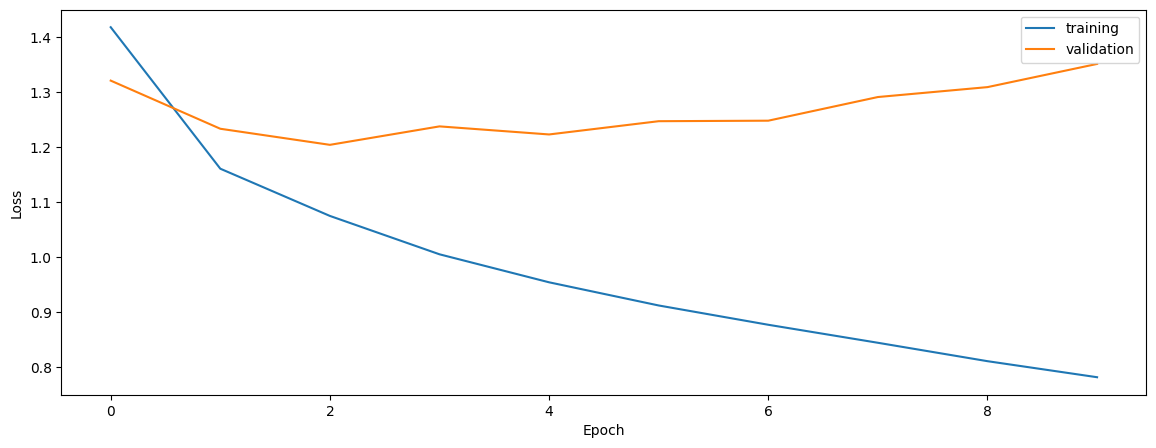

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.5973665239153223
0.5346363636363637
0.552553453813958


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5555399741760684
0.5353196160142878
0.5432386713143326


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.54261494838803
0.5232075918153853
0.5229307319394462


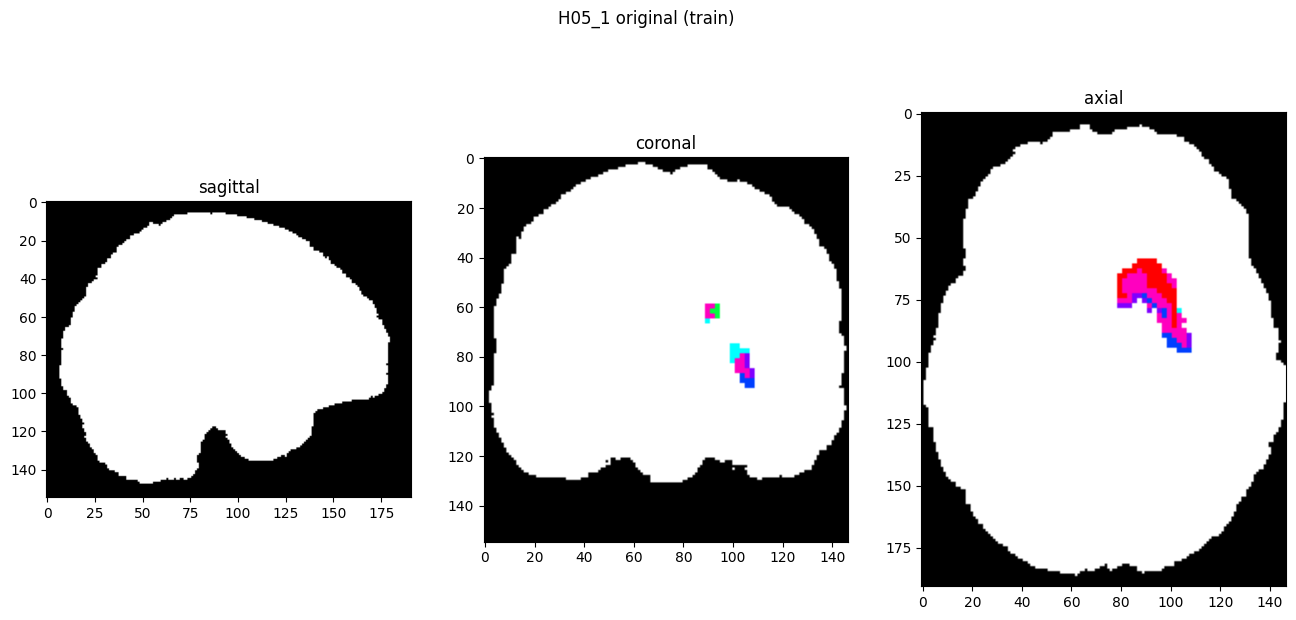

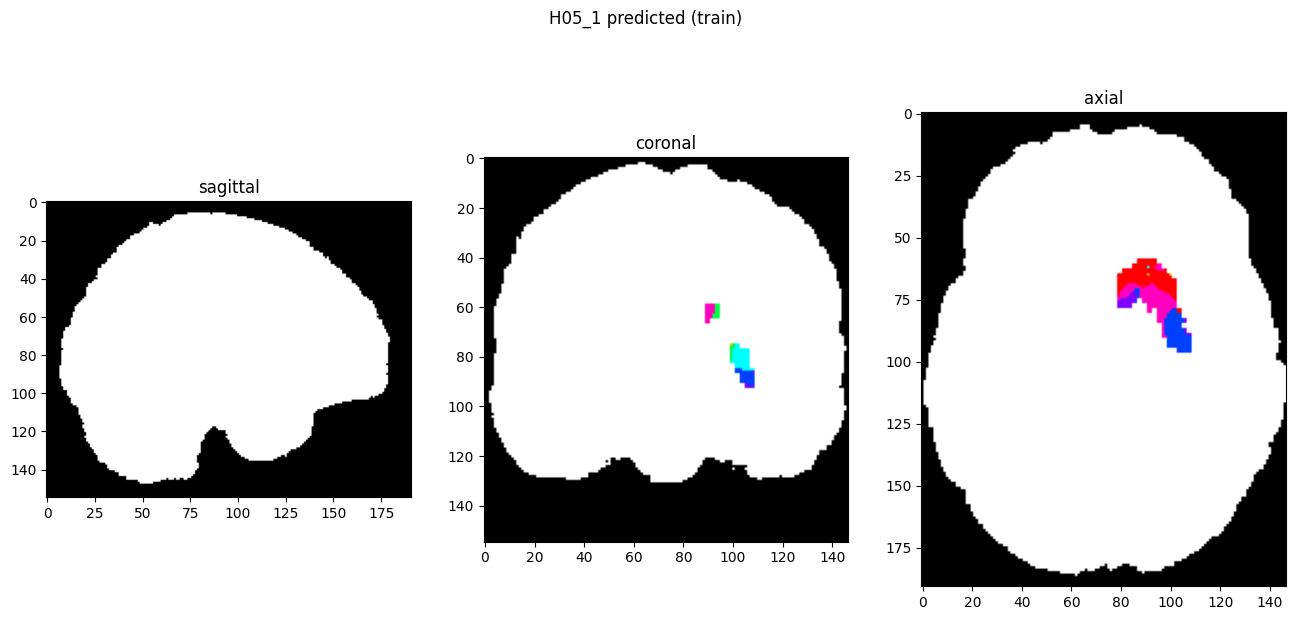

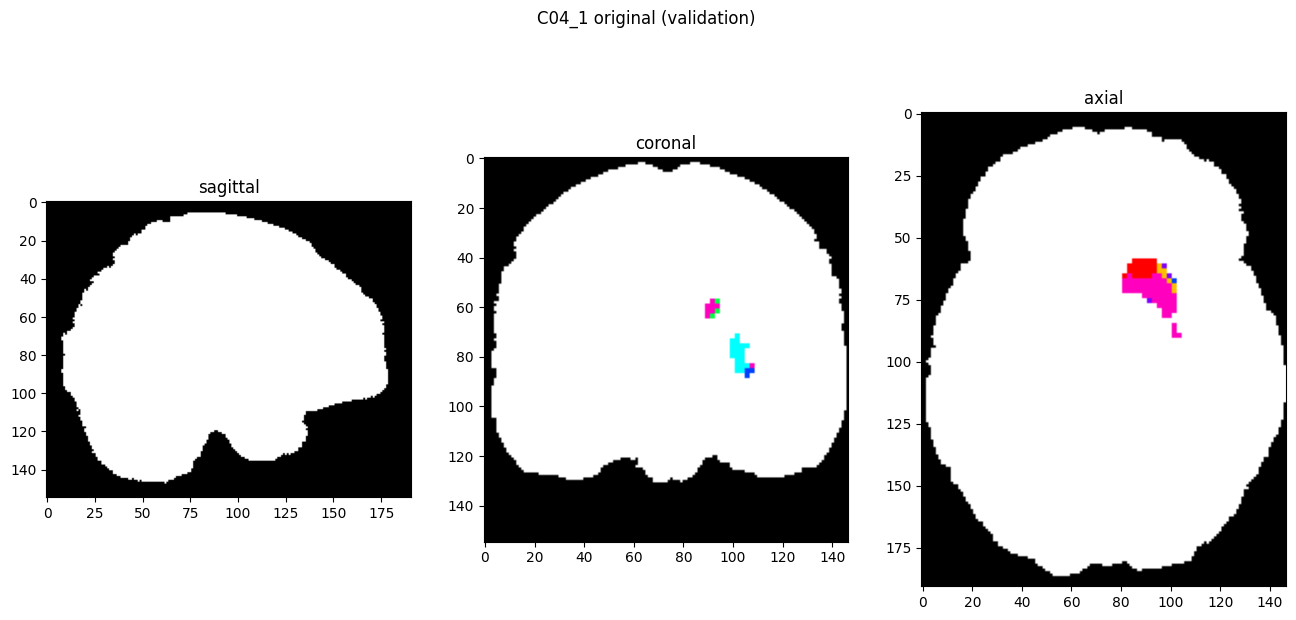

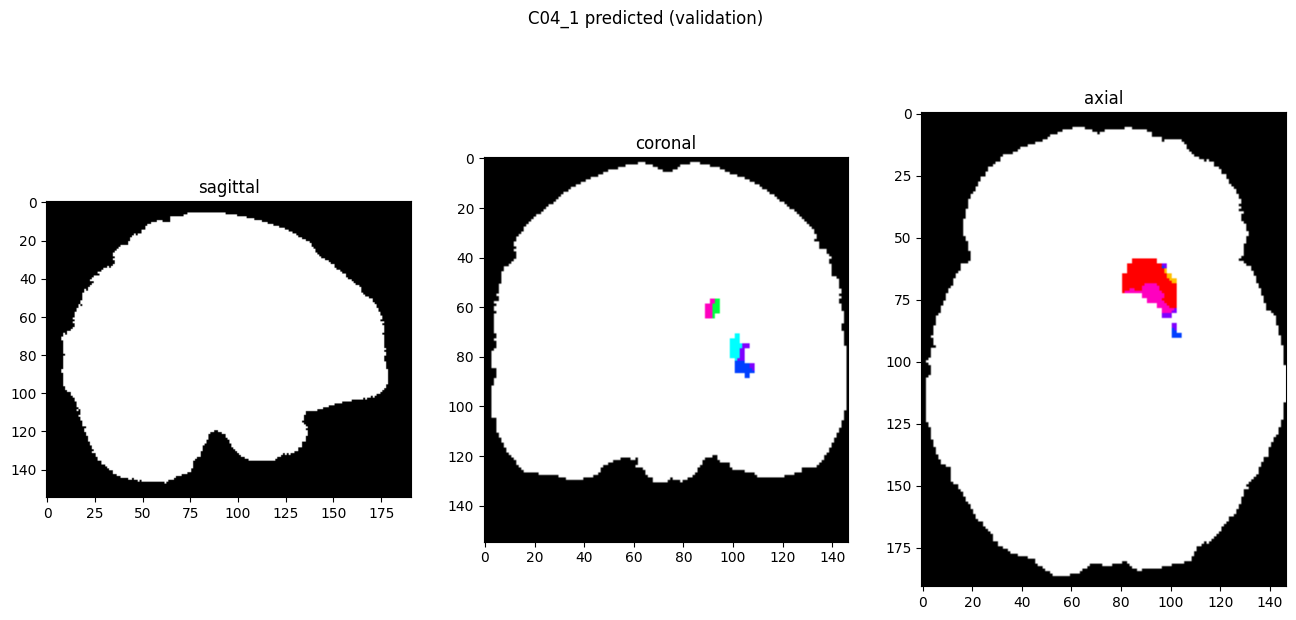

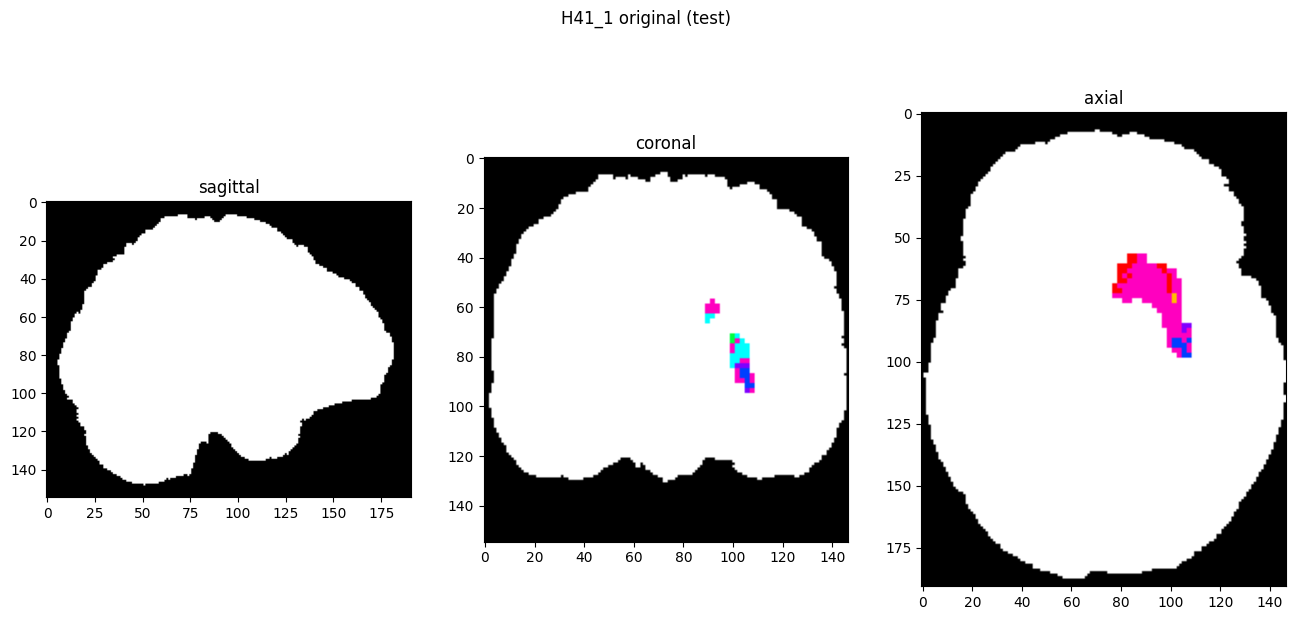

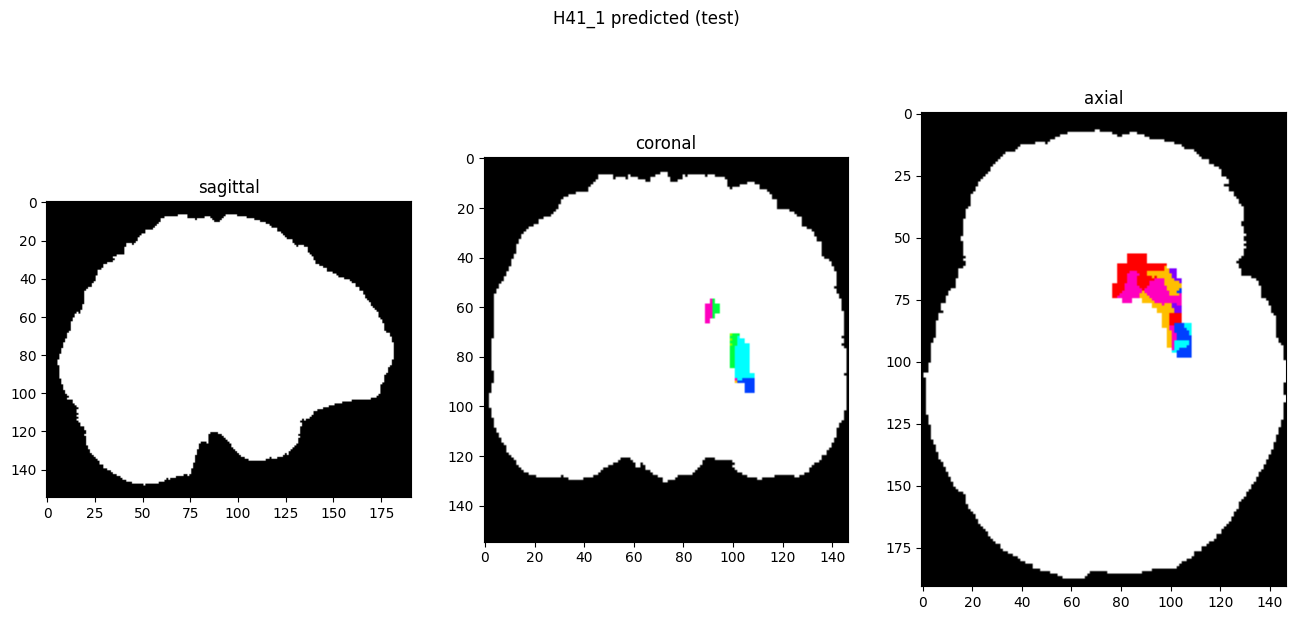

In [10]:
showResults(model, gen, threshold=0)